<h1>Analysis 3 - Time series analysis using Ensemble methods</h1>

This is based on Shaohua Liu workbook Analysis 2 (20/5/2021)

<h2>Section 1 - Preprocessing</h2>

TK - 23/8/2021 - INCLUDE THE MASE MEASURE: https://github.com/CamDavidsonPilon/Python-Numerics/blob/master/TimeSeries/MASE.py

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import requests
import json
import seaborn as sns
import re
from datetime import datetime
from datetime import date
from datetime import timedelta

In [2]:
def parse_CL(site):
    df = pd.concat([pd.read_csv(file) for file in glob(f'Ceilometer/*{site}.csv')])

    # replace -999 to NaN
    df = df.replace(-999, np.nan)

    # parse date string
    df['# Time'] = pd.to_datetime(df['# Time'], format='%d/%m/%Y %H:%M:%S')
    
    # interpolate bl_height by time
    df['revised_bl_height'] = df.set_index('# Time')['bl_height'].interpolate(method='time').values

    # aggregate bl_height by hourly average
    df = df.groupby([
        df['# Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['# Time'].dt.hour.rename('Hour')
    ])['revised_bl_height'].mean().reset_index(name='CL_BLH').set_index(['Date', 'Hour'])

    return df

In [3]:
def parse_CTM(site, time_offset=10):
    # Careful! The seperator is not ',' but ', ' (space)
    df = pd.concat([pd.read_csv(file, sep=r'\s*,\s*', engine='python') for file in glob(f'CTM_ModelOutput/*{site}.csv')])

    # parse date string
    from datetime import timedelta
    df['Time'] = pd.to_datetime(df[['date', 'time']].astype(str).apply('-'.join, 1), format='%Y%m%d-%H') + timedelta(hours=time_offset)

    df = df.groupby([
        df['Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['Time'].dt.hour.rename('Hour')
    ])['mixing_height'].mean().reset_index(name='CTM_BLH').set_index(['Date', 'Hour'])

    return df

In [4]:
def convert_df_to_datetime_wrf(df):
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d_%H:%M:%S')+ timedelta(hours=10)
    
    #Set index to datetime
    df = df.set_index('datetime')
    
    #Keep the last index
    #As per Hiep response - 24/8/2021 - we keep last value

    df = df[~df.index.duplicated(keep = 'last')]

    df = df.reset_index()
    #Set index to datetime
    df = df.groupby([
        df['datetime'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['datetime'].dt.hour.rename('Hour')
    ])['WRF PBLH'].mean().reset_index(name='WRF_BLH').set_index(['Date', 'Hour'])

    
    return df

In [5]:
'''
2. Import WRF data and parse accordingly
'''

data_path = "D:\MSDS\DS Project\Data"

wrf_data_path = "\\WRF"

wrf_data_fn_merriwa = ['PBLH_series329_20210212', 'PBLH_series329_20210213',
                       'PBLH_series329_20210214','PBLH_series329_20210215',
                       'PBLH_series329_20210216','PBLH_series329_20210217',
                      'PBLH_series329_20210218']

#Use RE
wrf_data_fn_lidcombe = [re.sub('series329', 'series2141',data) for data in wrf_data_fn_merriwa]

wrf_full_file_path_merriwa = [data_path+wrf_data_path+'\\'+path+'.txt' for path in wrf_data_fn_merriwa]
wrf_full_file_path_lidcombe = [data_path+wrf_data_path+'\\'+path+'.txt' for path in wrf_data_fn_lidcombe]

#Initialise a Dataframe with first table
wrf_df_merriwa = pd.read_csv(wrf_full_file_path_merriwa[0], header = None, delimiter = r'\s+')
wrf_df_lidcombe = pd.read_csv(wrf_full_file_path_lidcombe[0], header = None, delimiter = r'\s+')

#Loop through the rest of the data and append. Note both data is same length
for i in range(1,len(wrf_full_file_path_merriwa)):
    wrf_df_merriwa = wrf_df_merriwa.append(pd.read_csv(wrf_full_file_path_merriwa[i], header = None, delimiter = r'\s+') , ignore_index = True)
    wrf_df_lidcombe = wrf_df_lidcombe.append(pd.read_csv(wrf_full_file_path_lidcombe[i], header=None, delimiter = r'\s+'),  ignore_index = True)
    
wrf_df_merriwa = wrf_df_merriwa.rename(columns = {0:'datetime', 1:'WRF PBLH'})
wrf_df_lidcombe = wrf_df_lidcombe.rename(columns = {0:'datetime', 1:'WRF PBLH'})


wrf_df_merriwa['date'] = wrf_df_merriwa.datetime.str[:10]
wrf_df_merriwa['time'] = wrf_df_merriwa.datetime.str[11:13].astype(int)

wrf_df_lidcombe['date'] = wrf_df_lidcombe.datetime.str[:10] 
wrf_df_lidcombe['time'] = wrf_df_lidcombe.datetime.str[11:13].astype(int)

wrf_df_merriwa = convert_df_to_datetime_wrf(wrf_df_merriwa)
wrf_df_lidcombe = convert_df_to_datetime_wrf(wrf_df_lidcombe)


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def join_CL_CTM_WRF(site, wrf_df):
    CLdf = parse_CL(site)
    CTMdf = parse_CTM(site)
    WRFdf = wrf_df.copy(deep = True)
    
    df_joined = CLdf.join(CTMdf, how='inner')
    
    df_joined = df_joined.join(WRFdf, how = 'inner')
    return df_joined

def bl_plot(site, wrf_df):
    join_df = join_CL_CTM_WRF(site, wrf_df).reset_index()
    join_df['Time'] = pd.to_datetime(join_df[['Date', 'Hour']].astype(str).apply('-'.join, 1), format='%Y-%m-%d-%H')
    join_df.plot(x='Time', y=['CL_BLH', 'CTM_BLH', 'WRF_BLH'], title=site)
    plt.show()

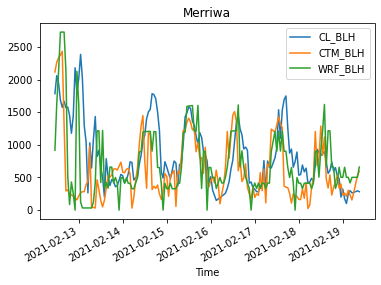

In [8]:
bl_plot('Merriwa', wrf_df_merriwa)


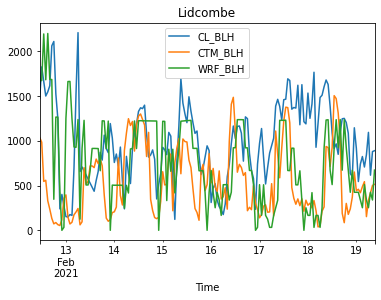

In [9]:
bl_plot('Lidcombe', wrf_df_lidcombe)


In [7]:
class AQMS_API:
    def __init__(self):
        self.url_prefix = 'https://data.airquality.nsw.gov.au/api/Data/'
        self.headers = {
            'content-type': 'application/json',
            'accept': 'application/json',
        }
        
        self.site_url = 'get_SiteDetails'
        self.parameter_url = 'get_ParameterDetails'
        self.observation_url = 'get_Observations'
        
    def get_data(self, url_suffix, http_method=requests.get, data=None):
        query = self.url_prefix + url_suffix
        response = http_method(url=query, headers=self.headers, json=data)
        return response.json()
    
    def get_sites(self):
        return self.get_data(self.site_url)
    
    def get_parameters(self):
        return self.get_data(self.parameter_url)
    
    def get_observations(self, data=None):
        return self.get_data(self.observation_url, requests.post, data)

# historical observation query builder
def obs_builder(parameter=None, sites=None, start=None, end=None, category=None, sub_category=None, freq=None):
    '''
    start & end : '%Y-%m-%d' format date string
    '''
    def list_parser(s):
        if s is None or isinstance(s, list):
            return s
        else:
            return [s]

    return {
        'Parameters': list_parser(parameter),
        'Sites': list_parser(sites),
        'StartDate': start,
        'EndDate': end,
        'Categories': list_parser(category),
        'SubCategories': list_parser(sub_category),
        'Frequency': list_parser(freq),
    }

In [8]:
api = AQMS_API()

# site id
sites = {
    'Merriwa': 329,
    'Lidcombe': 1141,
}

In [9]:
df = pd.DataFrame.from_records(api.get_parameters())
params = df.loc[
    (df['Category'] == 'Averages') & 
    (df['SubCategory'] == 'Hourly') & 
    (df['Frequency'] == 'Hourly average')
]
#params

In [17]:
#TK 28/7/2021: Added BL diff - can/should we use this as a feature..?
def bl_external(site, site_id):
    query = obs_builder(
        params['ParameterCode'].tolist(), 
        site_id, 
        '2021-02-12',
        '2021-02-20',
        'Averages', 
        'Hourly', 
        'Hourly average'
    )
    obs = pd.DataFrame.from_records(api.get_observations(query))
    obs['Hour'] = obs['Hour'] - 1
    obs['Parameter'] = pd.json_normalize(obs['Parameter'])['ParameterDescription']
    obs = pd.pivot(obs, index=['Date', 'Hour'], columns='Parameter', values='Value').reset_index()
    
    if site == 'Merriwa':
        wrf_df = wrf_df_merriwa
    else:
        wrf_df = wrf_df_lidcombe
    
    df = join_CL_CTM_WRF(site, wrf_df).join(obs.set_index(['Date', 'Hour']), how='inner').reset_index()
    df['BL_diff'] =df['CL_BLH'] - df['CTM_BLH'] 
    return df

In [9]:
#df = bl_external('Merriwa', 329)
#df

In [18]:
data = {site: bl_external(site, id) for site, id in sites.items()}

<h2>Section 2 - Correlation analysis</h2>

In [21]:
def get_df(site):
    if site == 'all':
        df = pd.concat(data.values()).drop(columns='Solar radiation')
    else:
        df = data[site]
    return df.dropna().set_index(['Date', 'Hour'])

def corr(site, method='pearson'):
    return get_df(site).corr(method=method)

from scipy.stats import pearsonr

def p_value(site):
    df = get_df(site)._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 6)
    return pvalues

In [22]:
corr('all', 'pearson').iloc[:, :3]

CL_BLH   CTM_BLH   WRF_BLH
CL_BLH                      1.000000  0.287952  0.441482
CTM_BLH                     0.287952  1.000000  0.499293
WRF_BLH                     0.441482  0.499293  1.000000
Carbon monoxide             0.092702 -0.184646  0.064033
Humidity                   -0.667230 -0.518442 -0.573834
Nephelometer                0.006918 -0.173402 -0.091688
Nitric Oxide                0.144480 -0.125607 -0.190166
Nitrogen Dioxide            0.011283 -0.424918 -0.286491
Ozone                       0.468203  0.455442  0.604818
PM10                        0.352813 -0.023971  0.132992
PM2.5                       0.017452 -0.217491 -0.121238
Rainfall                   -0.071116 -0.132322 -0.052655
Sulphur Dioxide            -0.019790 -0.015797  0.012757
Temperature                 0.623792  0.358214  0.633670
Wind Direction (10m)        0.336327  0.031271  0.292651
Wind Direction Sigma Theta  0.198841 -0.131882 -0.027195
Wind Speed (10m)           -0.060436  0.378731  0.249982
BL_diff                     0.623906 -0.568744 -0.028270

In [23]:
p_value('all').iloc[:, :3]

CL_BLH   CTM_BLH   WRF_BLH
CL_BLH                           0.0  0.000001       0.0
CTM_BLH                     0.000001       0.0       0.0
WRF_BLH                          0.0       0.0       0.0
Carbon monoxide             0.125132  0.002108      0.29
Humidity                         0.0       0.0       0.0
Nephelometer                0.909081  0.003923  0.129332
Nitric Oxide                0.016502  0.037367  0.001534
Nitrogen Dioxide            0.852237       0.0  0.000001
Ozone                            0.0       0.0       0.0
PM10                             0.0  0.692281  0.027441
PM2.5                       0.773255  0.000279  0.044562
Rainfall                     0.23982  0.028238  0.384406
Sulphur Dioxide             0.743882  0.794254  0.833196
Temperature                      0.0       0.0       0.0
Wind Direction (10m)             0.0  0.605624  0.000001
Wind Direction Sigma Theta  0.000915  0.028771  0.653429
Wind Speed (10m)            0.318004       0.0  0.000027
BL_diff                          0.0       0.0  0.640674

In [24]:
# available method [‘pearson’, ‘kendall’, ‘spearman’]
corr('Lidcombe', 'pearson').iloc[:, :3]

CL_BLH   CTM_BLH   WRF_BLH
CL_BLH                      1.000000  0.136481  0.267289
CTM_BLH                     0.136481  1.000000  0.252945
WRF_BLH                     0.267289  0.252945  1.000000
Carbon monoxide            -0.284860 -0.460941 -0.016028
Humidity                   -0.576953 -0.437755 -0.461386
Nephelometer               -0.313251 -0.311381 -0.355584
Nitric Oxide                0.152507 -0.249707 -0.393942
Nitrogen Dioxide           -0.013995 -0.600630 -0.424046
Ozone                       0.328640  0.399086  0.682951
PM10                        0.138696 -0.119004  0.024672
PM2.5                      -0.148077 -0.148062 -0.088080
Rainfall                   -0.088850 -0.193913 -0.030936
Solar radiation             0.389137  0.645485  0.410196
Sulphur Dioxide             0.070599 -0.143544  0.230972
Temperature                 0.482661  0.187751  0.648183
Wind Direction (10m)        0.186592 -0.118215  0.401912
Wind Direction Sigma Theta  0.226398 -0.226359 -0.055867
Wind Speed (10m)           -0.034239  0.540128  0.371995
BL_diff                     0.697656 -0.614513  0.029928

In [25]:
p_value('Lidcombe').iloc[:, :3]

CL_BLH   CTM_BLH   WRF_BLH
CL_BLH                           0.0  0.140567  0.003433
CTM_BLH                     0.140567       0.0  0.005718
WRF_BLH                     0.003433  0.005718       0.0
Carbon monoxide             0.001769       0.0  0.863229
Humidity                         0.0  0.000001       0.0
Nephelometer                0.000553  0.000599  0.000078
Nitric Oxide                0.099213  0.006392   0.00001
Nitrogen Dioxide            0.880438       0.0  0.000002
Ozone                        0.00028  0.000008       0.0
PM10                        0.134177   0.19931  0.790856
PM2.5                       0.109546  0.109581  0.342901
Rainfall                    0.338681  0.035377  0.739473
Solar radiation             0.000013       0.0  0.000004
Sulphur Dioxide             0.447444  0.120966  0.011855
Temperature                      0.0  0.041758       0.0
Wind Direction (10m)        0.043059  0.202327  0.000006
Wind Direction Sigma Theta  0.013692  0.013709  0.547917
Wind Speed (10m)            0.712818       0.0  0.000034
BL_diff                          0.0       0.0  0.747668

In [26]:
corr('Merriwa', 'pearson').iloc[:, :3]

CL_BLH   CTM_BLH   WRF_BLH
CL_BLH                      1.000000  0.395865  0.543841
CTM_BLH                     0.395865  1.000000  0.644584
WRF_BLH                     0.543841  0.644584  1.000000
Carbon monoxide             0.522859  0.200391  0.366328
Humidity                   -0.755757 -0.597379 -0.669819
Nephelometer               -0.128754 -0.089435 -0.035741
Nitric Oxide                0.052930  0.150851  0.126244
Nitrogen Dioxide           -0.104132 -0.312676 -0.243391
Ozone                       0.695825  0.497777  0.613572
PM10                        0.475645  0.091247  0.211689
PM2.5                       0.078824 -0.245054 -0.154571
Rainfall                   -0.065411 -0.131461 -0.060201
Sulphur Dioxide             0.056690 -0.046874  0.029063
Temperature                 0.692539  0.527734  0.650573
Wind Direction (10m)        0.400062  0.127651  0.219515
Wind Direction Sigma Theta  0.005815  0.010209 -0.101372
Wind Speed (10m)            0.109970  0.399278  0.373144
BL_diff                     0.554197 -0.544999 -0.087732

In [27]:
p_value('Merriwa').iloc[:, :3]

CL_BLH   CTM_BLH   WRF_BLH
CL_BLH                           0.0       0.0       0.0
CTM_BLH                          0.0       0.0       0.0
WRF_BLH                          0.0       0.0       0.0
Carbon monoxide                  0.0  0.011856  0.000002
Humidity                         0.0       0.0       0.0
Nephelometer                0.108036  0.265323  0.656758
Nitric Oxide                0.510299  0.059313  0.115142
Nitrogen Dioxide            0.194331  0.000067  0.002129
Ozone                            0.0       0.0       0.0
PM10                             0.0  0.255725   0.00778
PM2.5                       0.326444   0.00198  0.053246
Rainfall                    0.415689  0.100763  0.453879
Sulphur Dioxide             0.480677  0.559919  0.717854
Temperature                      0.0       0.0       0.0
Wind Direction (10m)             0.0  0.111114  0.005739
Wind Direction Sigma Theta  0.942383  0.899019  0.206482
Wind Speed (10m)            0.170352       0.0  0.000001
BL_diff                          0.0       0.0  0.274567

<h2>Section 3 - Ensemble modelling</h3>

<h4>Data config</h4>

In [28]:
#Get data from dict
df_merriwa = data['Merriwa']
df_lidcombe = data['Lidcombe']

#sanity check
#df_merriwa

In [30]:
df_lidcombe

Date  Hour       CL_BLH    CTM_BLH  WRF_BLH  Carbon monoxide  \
0    2021-02-12    11  1474.222222  1035.7593  1669.35         0.149364   
1    2021-02-12    12  1826.222222   984.8432  1674.54         0.146080   
2    2021-02-12    13  1662.444444   546.3094  2194.04         0.146025   
3    2021-02-12    14  1500.755556   559.0942  1682.49         0.153295   
4    2021-02-12    15  1546.844444   330.0530  2199.28         0.154233   
..          ...   ...          ...        ...      ...              ...   
162  2021-02-19     5   845.268328   152.9865   338.62         0.108488   
163  2021-02-19     6  1094.350000   335.2351   253.00         0.125778   
164  2021-02-19     7   616.111111   417.5187   425.39         0.100724   
165  2021-02-19     8   879.903145   501.2411   338.98         0.073916   
166  2021-02-19     9   889.407966   513.3745   673.04         0.059124   

     Humidity  Nephelometer   Nitric Oxide  Nitrogen Dioxide  ...    PM10  \
0      38.903          0.098      0.056400          0.432441  ...  19.175   
1      41.071          0.098      0.032354          0.480973  ...  21.087   
2      37.793          0.105      0.035266          0.328856  ...  22.598   
3      33.679          0.104      0.036560          0.345746  ...  21.240   
4      33.654          0.100      0.016396          0.400050  ...  22.086   
..        ...            ...           ...               ...  ...     ...   
162    95.137          0.358      0.084657          0.754212  ...  24.486   
163    99.544          0.354      0.347748          0.962891  ...  28.849   
164    85.626          0.390      0.208687          0.526319  ...  25.040   
165    72.780          0.336      0.087252          0.103809  ...  23.031   
166    67.648          0.278      0.083143          0.060871  ...  19.910   

     PM2.5  Rainfall  Solar radiation  Sulphur Dioxide  Temperature  \
0    0.367       0.0          437.536         0.089996       29.653   
1    0.158       0.0          461.103         0.078456       29.344   
2    5.190       0.0          955.920         0.060462       31.621   
3    7.388       0.0          747.303         0.068090       33.368   
4    2.361       0.0          413.177         0.066623       33.113   
..     ...       ...              ...              ...          ...   
162  4.106       2.4            3.262        -0.015445       20.604   
163  4.764       0.0           79.226        -0.010618       20.732   
164  5.870       0.0          164.262        -0.014756       22.176   
165  2.794       0.0          658.881        -0.007662       24.262   
166  6.684       0.0          659.337        -0.010125       24.903   

     Wind Direction (10m)   Wind Direction Sigma Theta  Wind Speed (10m)    \
0                  331.739                      26.645               2.549   
1                  341.122                      26.520               2.536   
2                  351.062                      28.473               3.029   
3                  345.062                      28.062               3.395   
4                  346.135                      28.148               2.763   
..                     ...                         ...                 ...   
162                 85.998                      43.991               1.010   
163                 75.933                      38.038               1.132   
164                 69.681                      25.592               2.175   
165                 68.341                      30.295               2.748   
166                 68.039                      30.062               2.865   

         BL_diff  
0     438.462922  
1     841.379022  
2    1116.135044  
3     941.661356  
4    1216.791444  
..           ...  
162   692.281828  
163   759.114900  
164   198.592411  
165   378.662045  
166   376.033466  

[167 rows x 21 columns]

In [31]:
'''
There are NaNs in external factors. Just fill them in. This as opposed to dropping data with missing values
'''
def interpolate_external_factors(df):

    df['datetime'] = pd.to_datetime(df['Date'] +' '+ df['Hour'].astype(str)+':00', format = '%Y-%m-%d %H:%M')

    feature_list_all = [feature for feature in df.columns][4:len(df.columns)-2]

    for feature in feature_list_all:
        df[feature] = df.set_index('datetime')[feature].interpolate(method='time').values
        
    return df

In [32]:
df_merriwa_filled = interpolate_external_factors(df_merriwa)
df_lidcombe_filled = interpolate_external_factors(df_lidcombe)

In [11]:
'''
Not really used - just for curiosity
'''
#Split data
#df_merriwa_cl = df_merriwa.drop(columns = ['CTM_BLH','BL_diff'])
#df_lidcombe_cl = df_lidcombe.drop(columns = ['CTM_BLH','BL_diff'])

#sanity check
#df_merriwa_cl

In [33]:
#Creates functions with lags and differences up to d
def create_data_lags(df, d):

    df_func = df.copy(deep = True)

    for i in range(d):
        col_name = 'CL_BLH_lag'+str(i+1)
        df_func[col_name] = df_func['CL_BLH'].shift(i+1)

    #Double for loop not the best - but want to keep factors at different locations to each other to easier view
    for i in range(d):
        col_name = 'CL_BLH_diff'+str(i+1)
        df_func[col_name] = df_func['CL_BLH'].diff(periods = i+1)
    
    return df_func

In [34]:
df_merriwa_wlags = create_data_lags(df_merriwa_filled, 5)
df_lidcombe_wlags = create_data_lags(df_lidcombe_filled, 5)

In [35]:
df_lidcombe_wlags.columns

Index(['Date', 'Hour', 'CL_BLH', 'CTM_BLH', 'WRF_BLH', 'Carbon monoxide',
       'Humidity', 'Nephelometer ', 'Nitric Oxide', 'Nitrogen Dioxide',
       'Ozone', 'PM10', 'PM2.5', 'Rainfall', 'Solar radiation',
       'Sulphur Dioxide', 'Temperature', 'Wind Direction (10m) ',
       'Wind Direction Sigma Theta', 'Wind Speed (10m)  ', 'BL_diff',
       'datetime', 'CL_BLH_lag1', 'CL_BLH_lag2', 'CL_BLH_lag3', 'CL_BLH_lag4',
       'CL_BLH_lag5', 'CL_BLH_diff1', 'CL_BLH_diff2', 'CL_BLH_diff3',
       'CL_BLH_diff4', 'CL_BLH_diff5'],
      dtype='object')

<h5>Defining the statistical comparison measures - as per analysis 1</h5>

In [36]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [37]:
'''
Sourced from: https://github.com/rkawsar/ambhas/blob/master/ambhas/errlib.py

This basically looks like a modified version of R2?
'''

def index_agreement(s, o):
    """
    index of agreement

    Willmott (1981, 1982) 
    input:
        s: simulated
        o: observed
    output:
        ia: index of agreement
    """
    ia = 1 -(np.sum((o-s)**2))/(np.sum((np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))
    return ia

In [38]:
'''
Calculate mean bias error
'''
def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)


In [39]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def DTW_dist(y_true, y_pred):
    distance, path = fastdtw(y_true, y_pred, dist=euclidean)
    
    return distance, path

In [44]:
'''
Sourced from: https://github.com/CamDavidsonPilon/Python-Numerics/blob/master/TimeSeries/MASE.py
'''

def MASE(training_series, testing_series, prediction_series):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    
    parameters:
        training_series: the series used to train the model, 1d numpy array
        testing_series: the test series to predict, 1d numpy array or float
        prediction_series: the prediction of testing_series, 1d numpy array (same size as testing_series) or float
        absolute: "squares" to use sum of squares and root the result, "absolute" to use absolute values.
    
    """
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d

In [40]:
'''
Function: Calculates and prints out the varoius metrics
'''

def satistical_comps_on_df(y_true, y_pred, train_series, location):    
    y_true = y_true.to_numpy()
    y_pred = y_pred.to_numpy()
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mbe = mean_bias_error(y_true, y_pred)
    ioa = index_agreement(y_pred, y_true)
    dtw_dist, path = DTW_dist(y_true, y_pred)
    mase = MASE(train_series, y_pred, y_true)
    
    print('At %s\nIndex of agreement:%.5f\nRoot mean squared error:%.5f\nMean absoluate error:%.5f\nMean bias error:%.5f\nDTW distance:%.2f\nMean Absolute scaled error:%.5f' % (location, ioa, rmse, mae, mbe, dtw_dist, mase))

In [41]:
#Write into DF
def satistical_comps_on_df_to_df(y_true, y_pred, train_series):    
    y_true = y_true.to_numpy()
    y_pred = y_pred.to_numpy()
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mbe = mean_bias_error(y_true, y_pred)
    ioa = index_agreement(y_pred, y_true)
    dtw_dist, path = DTW_dist(y_true, y_pred)
    mase = MASE(train_series, y_pred, y_true)
    
    df = pd.DataFrame([ioa, rmse, mae, mbe, dtw_dist, mase])
    
    return df

<h5>Base comp stats - assuming gold standard is CT and WRF model</h5>

On CTM

In [45]:
satistical_comps_on_df(df_merriwa_filled.tail(24)['CL_BLH'], df_merriwa_filled.tail(24)['CTM_BLH'],df_merriwa_filled.head(142)['CL_BLH'] , 'Merriwa CTM model')

At Merriwa CTM model
Index of agreement:0.83320
Root mean squared error:212.95909
Mean absoluate error:171.77558
Mean bias error:-21.58962
DTW distance:3611.44
Mean Absolute scaled error:0.90875


In [46]:
satistical_comps_on_df(df_lidcombe_filled.tail(24)['CL_BLH'], df_lidcombe_filled.tail(24)['CTM_BLH'],df_lidcombe_filled.head(142)['CL_BLH']  ,'Lidcombe CTM model')

At Lidcombe CTM model
Index of agreement:0.39774
Root mean squared error:585.35820
Mean absoluate error:505.07921
Mean bias error:-375.16142
DTW distance:12043.29
Mean Absolute scaled error:2.29637


On WRF

In [47]:
satistical_comps_on_df(df_merriwa_filled.tail(24)['CL_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'],df_merriwa_filled.head(142)['CL_BLH'] , 'Merriwa WRF model')

At Merriwa WRF model
Index of agreement:0.64856
Root mean squared error:334.31197
Mean absoluate error:275.83183
Mean bias error:194.63318
DTW distance:5639.22
Mean Absolute scaled error:1.45925


In [48]:
satistical_comps_on_df(df_lidcombe_filled.tail(24)['CL_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'], df_lidcombe_filled.head(142)['CL_BLH'] ,'Lidcombe WRF model')

At Lidcombe WRF model
Index of agreement:0.58391
Root mean squared error:426.73064
Mean absoluate error:355.98713
Mean bias error:-308.86867
DTW distance:6127.69
Mean Absolute scaled error:1.61852


<h5>Feature list</h5>

In [49]:
feature_list = ['Carbon monoxide',
 'Humidity',
 'Nephelometer ',
 'Ozone',
 'Temperature',
 'Wind Direction Sigma Theta']

In [50]:
feature_list_all = [feature for feature in df_merriwa.columns][5:len(df_merriwa.columns)-2]

# feature_list_all

In [51]:
#Feature including BL diff as predictor.
feature_list_all_v2 = [feature for feature in df_merriwa.columns][5:len(df_merriwa.columns)-1]

In [52]:
#Feature list with lags
feature_list_all_wlags = feature_list_all.copy()

feature_list_all_wlags.extend(['CL_BLH_lag1', 'CL_BLH_lag2','CL_BLH_lag3','CL_BLH_lag4','CL_BLH_lag5'])

# feature_list_all_wlags

In [53]:
#extend feature list with lags to include diffs:
feature_list_all_v3 = feature_list_all_wlags.copy()

feature_list_all_v3.extend(['CL_BLH_diff1', 'CL_BLH_diff2','CL_BLH_diff3','CL_BLH_diff4','CL_BLH_diff5'])

# feature_list_all_v3

<h5>Generic modelling functions</h5>

In [54]:
'''
Define a generic modeller function

Inputs:
- df: dataframe object
- feature_list: list of features
- target: target variable
- modeller: base model to fit

Returns:
- df_result: dataframe of results

'''
def modeller(df, feature_list, target, modeller):
    '''
    Define train test split
    '''
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    '''
    Train model
    '''
    modeller.fit(X_train, y_train)

    '''
    Predict
    '''
    modeller_predict = modeller.predict(X_test)
    
    '''
    Write to dataframe
    '''
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  modeller_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    return df_result


In [55]:
def pred_plots(df, title):
    resid_plot_title = 'Residual plots at '+ title
    pred_plot_title = 'Comparison of predicted BLH at ' + title
    
    sns.set_theme(style="whitegrid")

    # Make an example dataset with y ~ x
    x = df['CL_BLH']
    y = df['Predicted BLH']

    # Plot the residuals after fitting a linear model
    sns.residplot(x=x, y=y, lowess=True, color="g").set(title = resid_plot_title)
    df.plot(title = pred_plot_title)

In [57]:
def results_print(df, train_series, title):
    pred_plots(df, title)
    satistical_comps_on_df(df['CL_BLH'], df['Predicted BLH'], train_series, title)

<h3>GBM methods</h3>

The idea is to use boosting methods as applied to time series based on feature set to develop an ensemble model. Will use linear regressors

4/8/2021 - General thoughts
* BM seem to work OK
* There are many different algos though - each with its own fine tuning needs
* Explore more ensemble methods?
* GBM vs Ada?

<h4>XGBoost</h4>

General thoughts:
* Easy to train
* Does this overfit as number of trees increase? Need to think carefully
* Tuning hyper-params?
* Feature selection still an issue - H0 tests? ANOVA?

In [58]:
from xgboost import XGBRegressor

<h5>On all features</h5>

In [59]:
# n_estimators=500, learning_rate=0.01

xgbm_model = XGBRegressor()

df_merriwa_xgbm_all = modeller(df_merriwa_filled, feature_list_all, 'CL_BLH', xgbm_model)
df_lidcombe_xgbm_all = modeller(df_lidcombe_filled, feature_list_all, 'CL_BLH', xgbm_model)

C:\Users\Thomas\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\Thomas\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


At Merriwa XGBM all features
Index of agreement:0.73466
Root mean squared error:319.03948
Mean absoluate error:280.90060
Mean bias error:280.90060
DTW distance:6940.82
Mean Absolute scaled error:1.48606


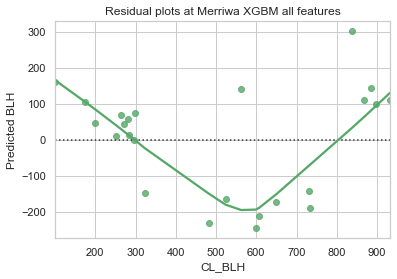

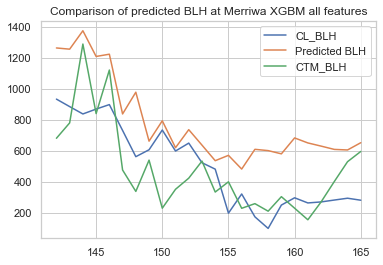

In [64]:
results_print(df_merriwa_xgbm_all, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa XGBM all features')

At Lidcombe XGBM all features
Index of agreement:0.55294
Root mean squared error:358.77947
Mean absoluate error:277.25321
Mean bias error:51.77140
DTW distance:6171.76
Mean Absolute scaled error:1.26055


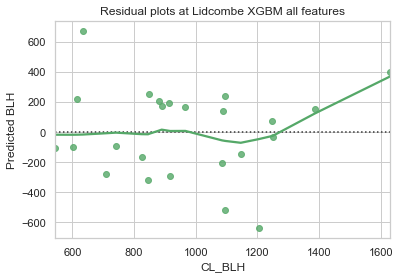

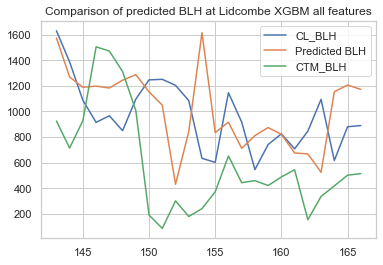

In [65]:
results_print(df_lidcombe_xgbm_all, df_lidcombe_filled.head(142)['CL_BLH'],'Lidcombe XGBM all features')

<h5>With lags</h5>

In [60]:
df_merriwa_xgbm_wlags = modeller(df_merriwa_wlags, feature_list_all_wlags, 'CL_BLH', xgbm_model)
df_lidcombe_xgbm_wlags = modeller(df_lidcombe_wlags, feature_list_all_wlags, 'CL_BLH', xgbm_model)

C:\Users\Thomas\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\Thomas\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


At Merriwa XGBM with lags
Index of agreement:0.73656
Root mean squared error:271.41178
Mean absoluate error:222.58251
Mean bias error:215.87148
DTW distance:3730.32
Mean Absolute scaled error:1.17754


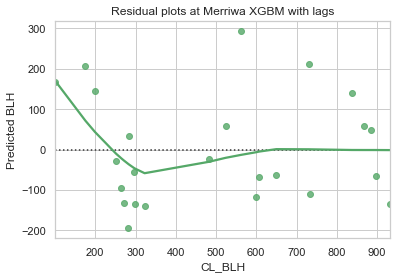

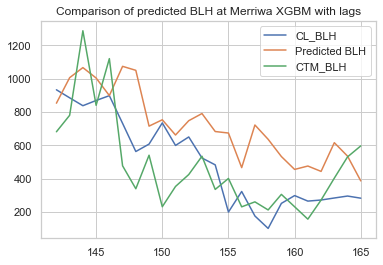

In [66]:
results_print(df_merriwa_xgbm_wlags, df_merriwa_filled.head(142)['CL_BLH'],'Merriwa XGBM with lags')

Clear improvement!!

At Lidcombe XGBM with lags
Index of agreement:0.75308
Root mean squared error:269.94877
Mean absoluate error:227.49795
Mean bias error:56.22532
DTW distance:3055.11
Mean Absolute scaled error:1.03433


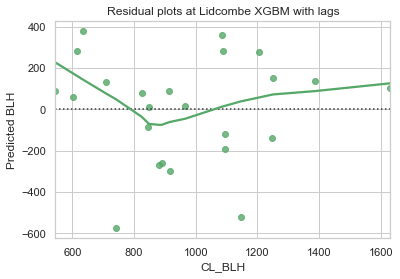

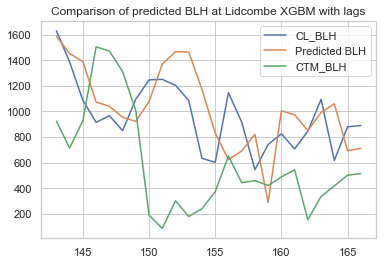

In [67]:
results_print(df_lidcombe_xgbm_wlags, df_lidcombe_filled.head(142)['CL_BLH'],'Lidcombe XGBM with lags')

<h5>With diff and lags</h5>

In [68]:
df_merriwa_xgbm_wlags_v2 = modeller(df_merriwa_wlags, feature_list_all_v3, 'CL_BLH', xgbm_model)
df_lidcombe_xgbm_wlags_v2 = modeller(df_lidcombe_wlags, feature_list_all_v3, 'CL_BLH', xgbm_model)

C:\Users\Thomas\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\Thomas\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


At Merriwa XGBM with lags and diffs
Index of agreement:0.94313
Root mean squared error:107.15248
Mean absoluate error:75.79342
Mean bias error:30.89492
DTW distance:1787.35
Mean Absolute scaled error:0.40097


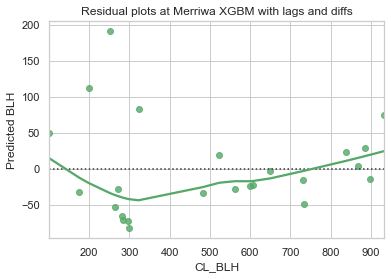

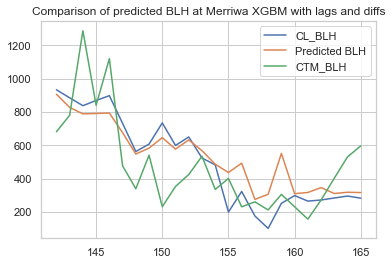

In [69]:
results_print(df_merriwa_xgbm_wlags_v2, df_merriwa_filled.head(142)['CL_BLH'],'Merriwa XGBM with lags and diffs')

At Merriwa XGBM with lags and diffs
Index of agreement:0.96467
Root mean squared error:94.97555
Mean absoluate error:71.32196
Mean bias error:-25.83419
DTW distance:1711.73
Mean Absolute scaled error:0.32427


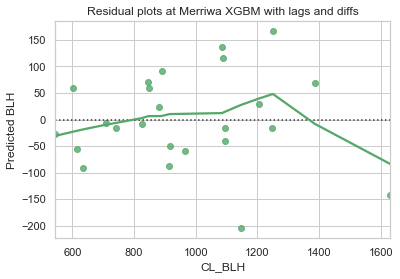

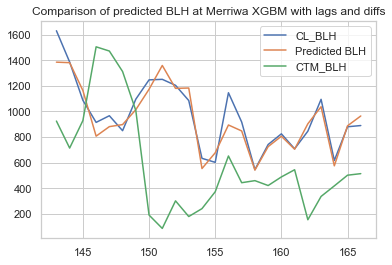

In [70]:
results_print(df_lidcombe_xgbm_wlags_v2, df_lidcombe_filled.head(142)['CL_BLH'],'Merriwa XGBM with lags and diffs')

<h5>Light GBM</h5>

In [71]:
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor()

#On external factors only
df_merriwa_lgbm_all = modeller(df_merriwa_filled, feature_list_all, 'CL_BLH', lgbm_model)
df_lidcombe_lgbm_all = modeller(df_lidcombe_filled, feature_list_all, 'CL_BLH', lgbm_model)

#On external factors with lags
df_merriwa_lgbm_wlags = modeller(df_merriwa_wlags, feature_list_all_wlags, 'CL_BLH', lgbm_model)
df_lidcombe_lgbm_wlags = modeller(df_lidcombe_wlags, feature_list_all_wlags, 'CL_BLH', lgbm_model)

#On external factors with lags and differences
df_merriwa_lgbm_wlags_v2 = modeller(df_merriwa_wlags, feature_list_all_v3, 'CL_BLH', lgbm_model)
df_lidcombe_lgbm_wlags_v2 = modeller(df_lidcombe_wlags, feature_list_all_v3, 'CL_BLH', lgbm_model)


At Merriwa LGBM all features
Index of agreement:0.65167
Root mean squared error:362.40321
Mean absoluate error:314.66247
Mean bias error:314.66247
DTW distance:6204.35
Mean Absolute scaled error:1.66467


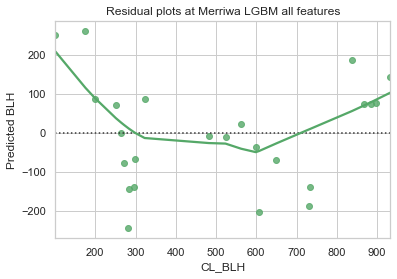

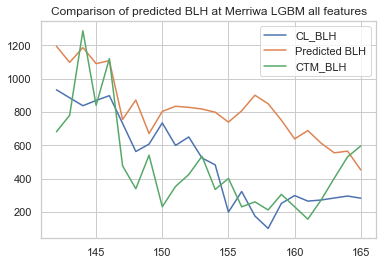

In [72]:
results_print(df_merriwa_lgbm_all, df_merriwa_filled.head(142)['CL_BLH'],'Merriwa LGBM all features')

At Lidcombe LGBM all features
Index of agreement:0.69446
Root mean squared error:270.12467
Mean absoluate error:226.50930
Mean bias error:88.98863
DTW distance:4192.09
Mean Absolute scaled error:1.02984


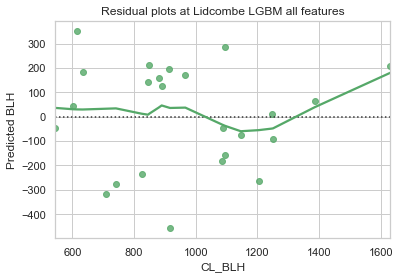

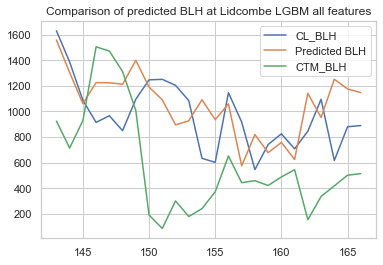

In [73]:
results_print(df_lidcombe_lgbm_all, df_lidcombe_filled.head(142)['CL_BLH'],'Lidcombe LGBM all features')

At Merriwa LGBM with lags
Index of agreement:0.75226
Root mean squared error:272.84479
Mean absoluate error:236.00363
Mean bias error:224.96256
DTW distance:2127.48
Mean Absolute scaled error:1.24854


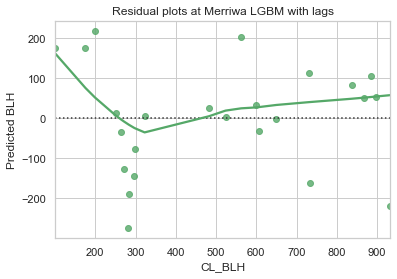

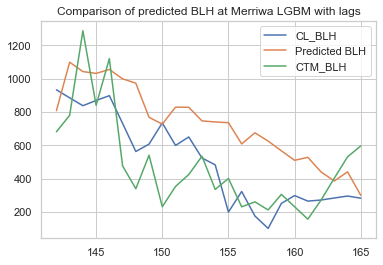

In [74]:
results_print(df_merriwa_lgbm_wlags, df_merriwa_filled.head(142)['CL_BLH'],'Merriwa LGBM with lags')

At Lidcombe LGBM with lags
Index of agreement:0.75213
Root mean squared error:255.45214
Mean absoluate error:213.66628
Mean bias error:48.95339
DTW distance:2869.95
Mean Absolute scaled error:0.97145


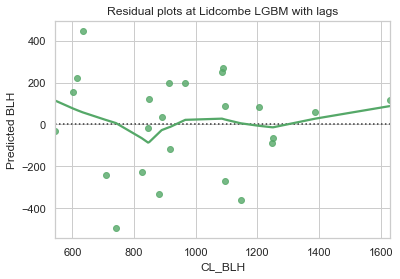

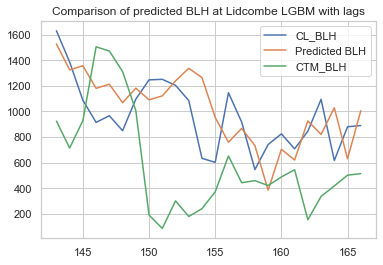

In [75]:
results_print(df_lidcombe_lgbm_wlags, df_lidcombe_filled.head(142)['CL_BLH'],'Lidcombe LGBM with lags')

<h5>AdaBoost</h5>

In [76]:
from sklearn.ensemble import AdaBoostRegressor

ada_model = AdaBoostRegressor()

#On external factors only
df_merriwa_ada_all = modeller(df_merriwa_filled, feature_list_all, 'CL_BLH', ada_model)
df_lidcombe_ada_all = modeller(df_lidcombe_filled, feature_list_all, 'CL_BLH', ada_model)

#On external factors with lags
df_merriwa_ada_wlags = modeller(df_merriwa_wlags, feature_list_all_wlags, 'CL_BLH', ada_model)
df_lidcombe_ada_wlags = modeller(df_lidcombe_wlags, feature_list_all_wlags, 'CL_BLH', ada_model)

#On external factors with lags and differences
df_merriwa_ada_wlags_v2 = modeller(df_merriwa_wlags, feature_list_all_v3, 'CL_BLH', ada_model)
df_lidcombe_ada_wlags_v2 = modeller(df_lidcombe_wlags, feature_list_all_v3, 'CL_BLH', ada_model)


When you rerun- you dont get same answer..?? Not stable perhaps discard

At Merriwa ADA all features
Index of agreement:0.70054
Root mean squared error:353.90042
Mean absoluate error:303.97045
Mean bias error:302.37146
DTW distance:5116.22
Mean Absolute scaled error:1.60811


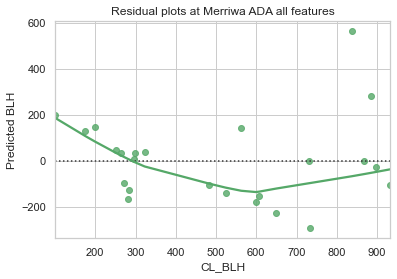

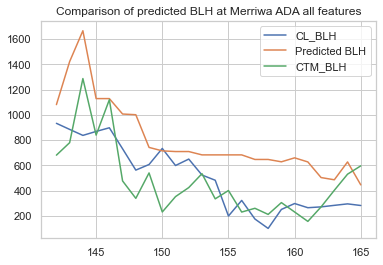

In [77]:
results_print(df_merriwa_ada_all, df_merriwa_filled.head(142)['CL_BLH'],'Merriwa ADA all features')

At Lidcombe ADA all features
Index of agreement:0.50751
Root mean squared error:294.21981
Mean absoluate error:248.06421
Mean bias error:98.82538
DTW distance:3542.72
Mean Absolute scaled error:1.12784


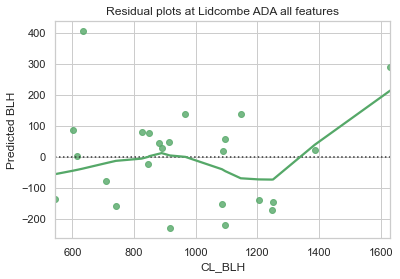

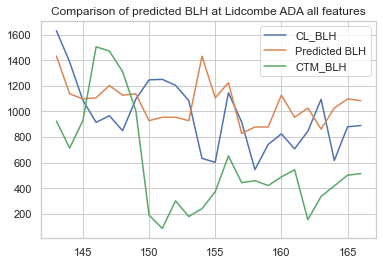

In [78]:
results_print(df_lidcombe_ada_all, df_lidcombe_filled.head(142)['CL_BLH'],'Lidcombe ADA all features')

At Merriwa ADA with lags
Index of agreement:0.78964
Root mean squared error:233.49224
Mean absoluate error:198.60105
Mean bias error:194.38311
DTW distance:3947.72
Mean Absolute scaled error:1.05067


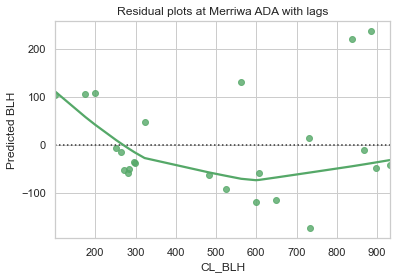

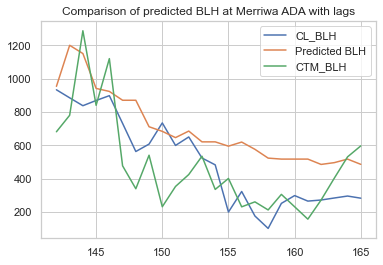

In [79]:
results_print(df_merriwa_ada_wlags, df_merriwa_filled.head(142)['CL_BLH'],'Merriwa ADA with lags')

At Lidcombe ADA with lags
Index of agreement:0.74306
Root mean squared error:232.17749
Mean absoluate error:185.19737
Mean bias error:56.42653
DTW distance:2345.43
Mean Absolute scaled error:0.84201


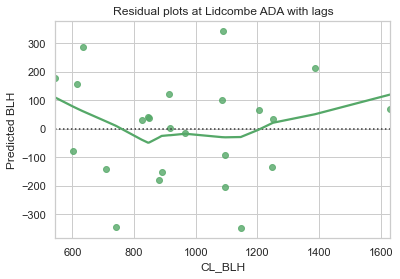

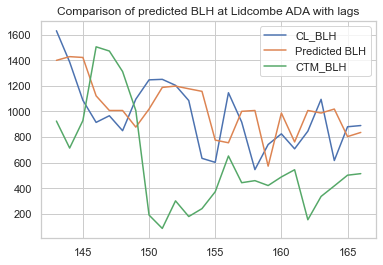

In [80]:
results_print(df_lidcombe_ada_wlags, df_lidcombe_filled.head(142)['CL_BLH'],'Lidcombe ADA with lags')

<h5>Random forest</h5>

Also not stable - forests typically dont converge i guess..

In [81]:
from sklearn.ensemble import RandomForestRegressor

def rf_modeller(df, feature_list, target):
    '''
    Define train test split
    '''
    train = df.head(142).dropna()
    test = df.tail(24)
    #These are different periods for Merriwa and Lidcombe!!!
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    '''
    Train model - keep default params
    '''
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    
    '''
    Predict
    '''
    rf_predict = rf.predict(X_test)
    
    '''
    Write to dataframe
    '''
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  rf_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    return df_result, rf

In [82]:
def feature_importance_plot(model, feature_list):
    feat_importances = pd.Series(model.feature_importances_, index=feature_list)
    feat_importances.nlargest(14).plot(kind='barh')

In [83]:
#Models

#On external factors only
df_rf_merriwa_all, rf_merriwa_all = rf_modeller(df_merriwa_filled, feature_list_all, 'CL_BLH')
df_rf_lidcombe_all, rf_lidcombe_all = rf_modeller(df_lidcombe_filled, feature_list_all, 'CL_BLH')

#On external factors with lags
df_rf_merriwa_wlags, rf_merriwa_wlags = rf_modeller(df_merriwa_wlags, feature_list_all_wlags, 'CL_BLH')
df_rf_lidcombe_wlags, rf_lidcombe_wlags = rf_modeller(df_lidcombe_wlags, feature_list_all_wlags, 'CL_BLH')

#On external factors with lags and differences
df_rf_merriwa_wlags_v2, rf_merriwa_v3 = rf_modeller(df_merriwa_wlags, feature_list_all_v3, 'CL_BLH')
df_rf_lidcombe_wlags_v2, rf_lidcombe_v3 = rf_modeller(df_lidcombe_wlags, feature_list_all_v3, 'CL_BLH')

At Merriwa RF all features
Index of agreement:0.73727
Root mean squared error:318.28575
Mean absoluate error:281.15335
Mean bias error:271.88689
DTW distance:6171.28
Mean Absolute scaled error:1.48740


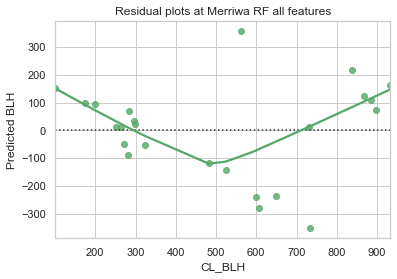

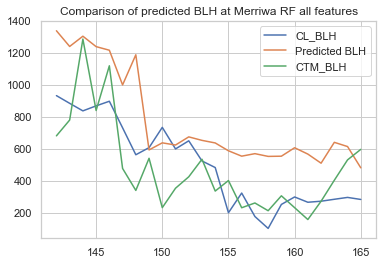

In [84]:
results_print(df_rf_merriwa_all, df_merriwa_filled.head(142)['CL_BLH'],'Merriwa RF all features')

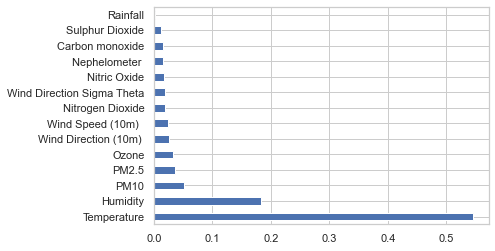

In [86]:
feature_importance_plot(rf_merriwa_all, feature_list_all)

At Lidcombe RF all features
Index of agreement:0.61151
Root mean squared error:279.07519
Mean absoluate error:234.79917
Mean bias error:71.41363
DTW distance:3744.39
Mean Absolute scaled error:1.06753


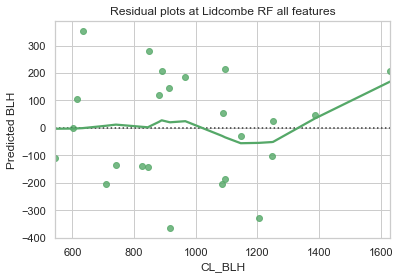

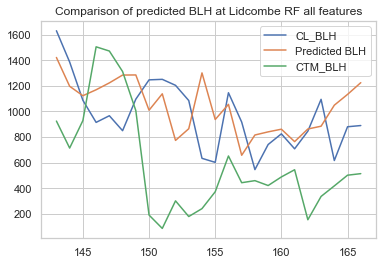

In [87]:
results_print(df_rf_lidcombe_all, df_lidcombe_filled.head(142)['CL_BLH'],'Lidcombe RF all features')

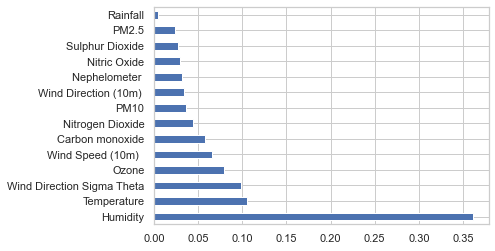

In [88]:
feature_importance_plot(rf_lidcombe_all, feature_list_all)

At Merriwa RF with lags
Index of agreement:0.80943
Root mean squared error:196.52981
Mean absoluate error:161.14280
Mean bias error:138.89199
DTW distance:2500.87
Mean Absolute scaled error:0.85250


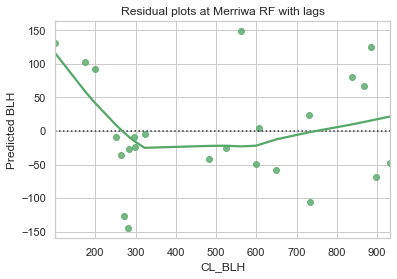

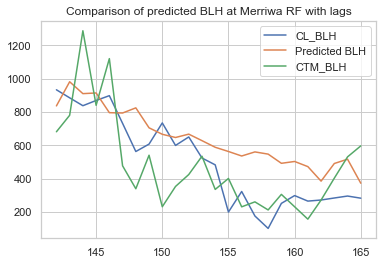

In [89]:
results_print(df_rf_merriwa_wlags, df_merriwa_filled.head(142)['CL_BLH'],'Merriwa RF with lags')

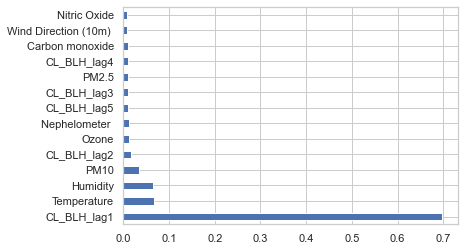

In [90]:
feature_importance_plot(rf_merriwa_wlags, feature_list_all_wlags)

Super interesting plot. The previous hour is the best indicator of the next hour's BLH. Heh

At Lidcombe RF with lags
Index of agreement:0.73352
Root mean squared error:250.83196
Mean absoluate error:197.72591
Mean bias error:52.35802
DTW distance:2121.36
Mean Absolute scaled error:0.89897


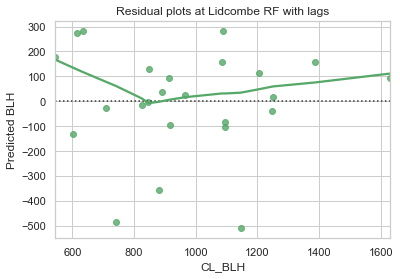

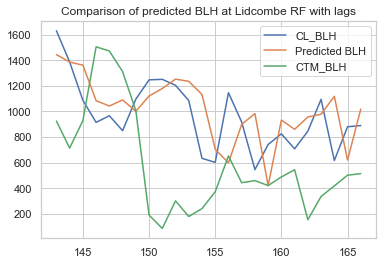

In [91]:
results_print(df_rf_lidcombe_wlags, df_lidcombe_filled.head(142)['CL_BLH'],'Lidcombe RF with lags')

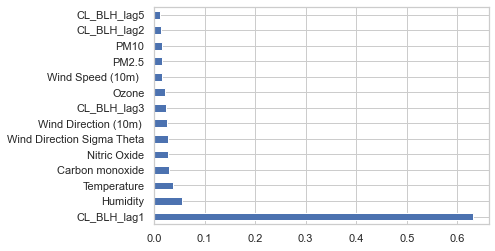

In [125]:
feature_importance_plot(rf_lidcombe_wlags, feature_list_all_wlags)

Same thing in Lidcombe. Cool

At Merriwa RF with lags and diff
Index of agreement:0.85119
Root mean squared error:159.79755
Mean absoluate error:120.88755
Mean bias error:41.71938
DTW distance:2274.83
Mean Absolute scaled error:0.63954


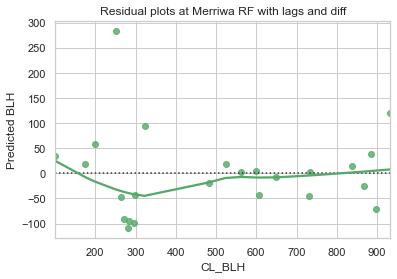

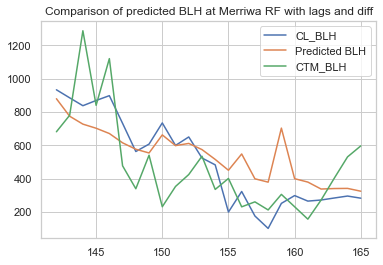

In [92]:
results_print(df_rf_merriwa_wlags_v2, df_merriwa_filled.head(142)['CL_BLH'],'Merriwa RF with lags and diff')

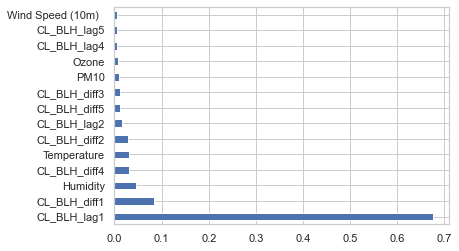

In [128]:
feature_importance_plot(rf_merriwa_v3, feature_list_all_v3)

<h5>Bagging regressor using linear SVR</h5>

In [93]:
from sklearn.ensemble import BaggingRegressor
from sklearn import svm

bagged_SVR_model = BaggingRegressor(base_estimator = svm.LinearSVR())

df_merriwa_svr_all = modeller(df_merriwa_filled, feature_list_all, 'CL_BLH', bagged_SVR_model)
df_lidcombe_svr_all = modeller(df_lidcombe_filled, feature_list_all, 'CL_BLH', bagged_SVR_model)

C:\Users\Thomas\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Thomas\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Thomas\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Thomas\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Thomas\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iter

At Merriwa SVR all features
Index of agreement:0.67737
Root mean squared error:315.79420
Mean absoluate error:278.43459
Mean bias error:274.65842
DTW distance:5287.31
Mean Absolute scaled error:1.47302


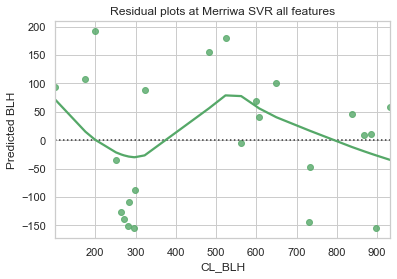

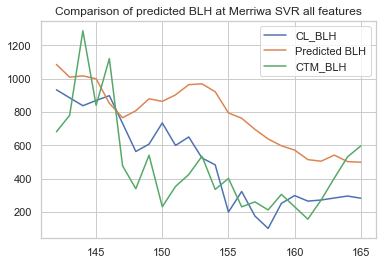

In [94]:
results_print(df_merriwa_svr_all, df_merriwa_filled.head(142)['CL_BLH'],'Merriwa SVR all features')

At Lidcombe SVR all features
Index of agreement:0.61657
Root mean squared error:238.49200
Mean absoluate error:191.86273
Mean bias error:35.12371
DTW distance:3341.66
Mean Absolute scaled error:0.87231


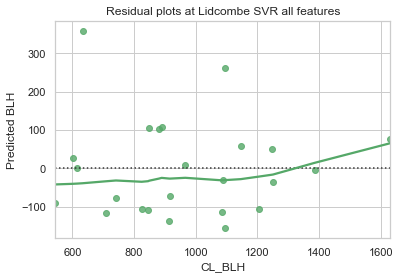

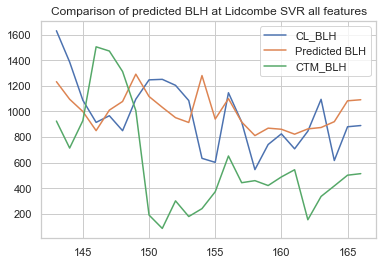

In [95]:
results_print(df_lidcombe_svr_all, df_lidcombe_filled.head(142)['CL_BLH'],'Lidcombe SVR all features')

<h5>Simple regression model with temp and humidity</h5>

In [96]:
feature_set_1 = ['Temperature', 'Humidity']

In [97]:
'''
Linear regression trainer
'''
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()

df_merriwa_lr_select1 = modeller(df_merriwa_filled, feature_set_1, 'CL_BLH', lr_model)
df_lidcombe_lr_select1 = modeller(df_lidcombe_filled, feature_list_all, 'CL_BLH', lr_model)

At LR Merriwa Temp and Humid
Index of agreement:0.70870
Root mean squared error:326.99635
Mean absoluate error:308.80200
Mean bias error:308.80200
DTW distance:6008.05
Mean Absolute scaled error:1.63367


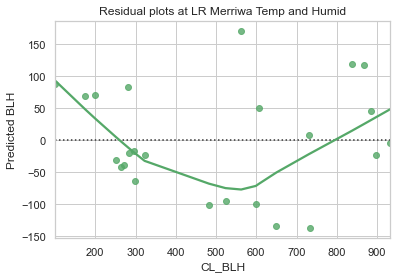

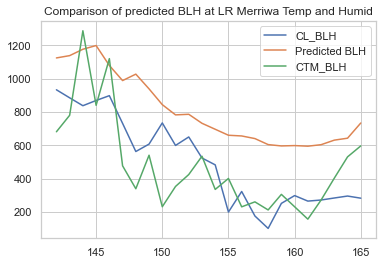

In [98]:
results_print(df_merriwa_lr_select1, df_merriwa_filled.head(142)['CL_BLH'],'LR Merriwa Temp and Humid')

At LR Lidcombe Temp and Humid
Index of agreement:0.37877
Root mean squared error:338.96714
Mean absoluate error:288.07691
Mean bias error:175.73330
DTW distance:5483.54
Mean Absolute scaled error:1.30976


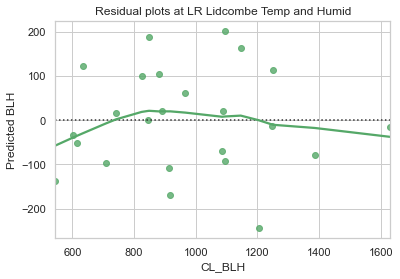

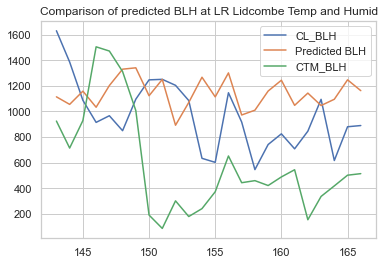

In [99]:
results_print(df_lidcombe_lr_select1, df_lidcombe_filled.head(142)['CL_BLH'],'LR Lidcombe Temp and Humid')

<h5> Summary section </h5>

NB: you need to have run the models below to plot.

In [100]:
def combine_data_plots(df_filled, results_df, col_names_df):
    time_stamp_index = df_filled.tail(24)['datetime']

    df_combined = pd.DataFrame(df_filled.tail(24)['CL_BLH'])

    for i in range(0, len(results_df)):
        df_combined[col_names_df[i]] = results_df[i]

    df_combined = df_combined.set_index(time_stamp_index)
    
    return df_combined


In [101]:
'''
Combining data for plots -define function
'''

results_df_merriwa = [df_merriwa_filled.tail(24)['CTM_BLH'],df_merriwa_filled.tail(24)['WRF_BLH'], df_merriwa_xgbm_all['Predicted BLH'], 
              df_merriwa_lgbm_all['Predicted BLH'], df_merriwa_ada_all['Predicted BLH'], 
              df_rf_merriwa_all['Predicted BLH'], df_merriwa_svr_all['Predicted BLH'], 
              df_merriwa_lr_select1['Predicted BLH']]

results_df_lidcombe = [df_lidcombe_filled.tail(24)['CTM_BLH'],df_lidcombe_filled.tail(24)['WRF_BLH'], df_lidcombe_xgbm_all['Predicted BLH'], 
              df_lidcombe_lgbm_all['Predicted BLH'], df_lidcombe_ada_all['Predicted BLH'], 
              df_rf_lidcombe_all['Predicted BLH'], df_lidcombe_svr_all['Predicted BLH'], 
              df_lidcombe_lr_select1['Predicted BLH']]

col_names_df = ['CTM BLH','WRF BLH', 'XGBM all', 
                'LGBM all', 'AdaBoost all', 
                'Random forest all', 'Bagged LinearSVR all', 
                ' Lin Reg Temp and Humidity']


df_combined_predicted_merriwa = combine_data_plots(df_merriwa_filled, results_df_merriwa, col_names_df)
df_combined_predicted_lidcombe = combine_data_plots(df_lidcombe_filled, results_df_lidcombe, col_names_df)

In [102]:
'''
Plots - define a function
'''
def combined_predicted_plots(df, title):
    ax = df.plot(figsize = (14,6), title = title)
    #Change settings for CL_BLH
    ax.lines[0].set_linestyle('dashed')
    ax.lines[0].set_linewidth(3)
    #Change settings for CTM BLH
    ax.lines[1].set_linestyle('dashed')
    ax.lines[2].set_linestyle('dashed')
    #Reset legend
    ax.legend()
    plt.xlabel('Date time')
    plt.ylabel('Boundary layer height (m)')

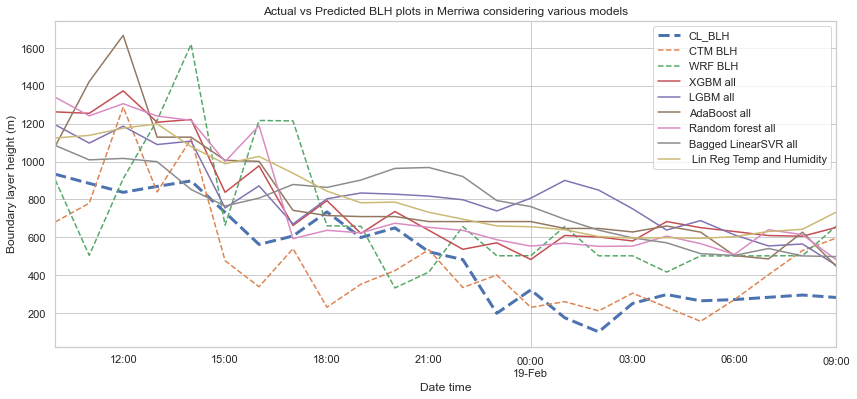

In [103]:
combined_predicted_plots(df_combined_predicted_merriwa, 'Actual vs Predicted BLH plots in Merriwa considering various models')

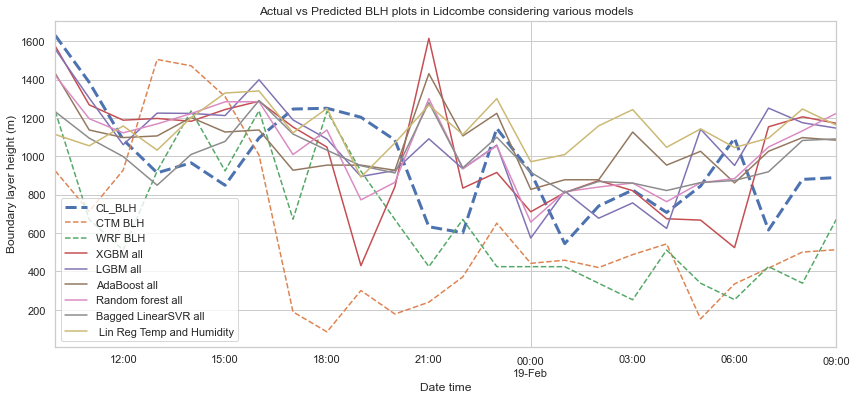

In [104]:
combined_predicted_plots(df_combined_predicted_lidcombe, 'Actual vs Predicted BLH plots in Lidcombe considering various models')

<h5>Using BL diff as a predictor</h5>

BL diff = CL_BLH - CTM_BLH i.e. the difference between the actual BLH and predicted BLH from CT model

How does this work if we include this as predictor?

feature_list_all_v2 has BL_diff included 

In [105]:
#Various ensemble methods on Merriwa
#Exclude bagged SVR
df_merriwa_xgbm_v2 = modeller(df_merriwa_filled, feature_list_all_v2, 'CL_BLH', xgbm_model)
df_merriwa_lgbm_v2 = modeller(df_merriwa_filled, feature_list_all_v2, 'CL_BLH', lgbm_model)
df_merriwa_ada_v2 = modeller(df_merriwa_filled, feature_list_all_v2, 'CL_BLH', ada_model)
df_merriwa_rf_v2, rf_merriwa_v2 = rf_modeller(df_merriwa_filled, feature_list_all_v2, 'CL_BLH')
# df_merriwa_svr_v2 = modeller(df_merriwa_filled, feature_list_all_v2, 'CL_BLH', bagged_SVR_model)


#Various ensemble methods at Lidcombe
df_lidcombe_xgbm_v2 = modeller(df_lidcombe_filled, feature_list_all_v2, 'CL_BLH', xgbm_model)
df_lidcombe_lgbm_v2 = modeller(df_lidcombe_filled, feature_list_all_v2, 'CL_BLH', lgbm_model)
df_lidcombe_ada_v2 = modeller(df_lidcombe_filled, feature_list_all_v2, 'CL_BLH', ada_model)
df_lidcombe_rf_v2, rf_lidcombe_v2 = rf_modeller(df_lidcombe_filled, feature_list_all_v2, 'CL_BLH')
# df_lidcombe_svr_v2 = modeller(df_lidcombe_filled, feature_list_all_v2, 'CL_BLH', bagged_SVR_model)


C:\Users\Thomas\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\Thomas\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


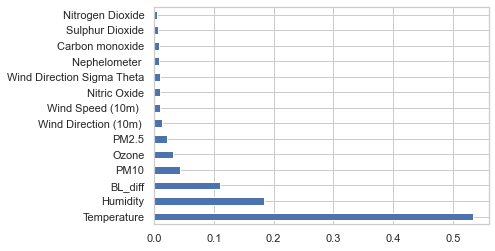

In [106]:
feature_importance_plot(rf_merriwa_v2, feature_list_all_v2)

Not as important as I was expecting

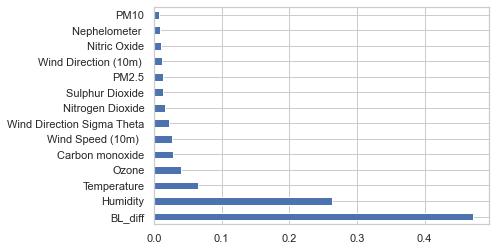

In [107]:
feature_importance_plot(rf_lidcombe_v2, feature_list_all_v2)

Now we're talking...

In [108]:
def combined_predicted_plots_v2(df, title):
    ax = df.plot(figsize = (14,6), title = title)
    #Change settings for CL_BLH
    ax.lines[0].set_linestyle('dashed')
    ax.lines[0].set_linewidth(3)
    #Change settings for CTM BLH
    ax.lines[1].set_linestyle('dashed')
    ax.lines[2].set_linestyle('dashed')
    
    
    ax.lines[6].set_color('red')
    ax.lines[6].set_linestyle('dotted')
    ax.lines[6].set_linewidth(2)
    
    ax.lines[7].set_color('purple')
    ax.lines[7].set_linestyle('dotted')
    ax.lines[7].set_linewidth(2)

    ax.lines[8].set_color('brown')
    ax.lines[8].set_linestyle('dotted')
    ax.lines[8].set_linewidth(2)

    #Reset legend
    ax.legend()
    plt.xlabel('Date time')
    plt.ylabel('Boundary layer height (m)')

In [109]:
results_df_merriwa_v2 = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'],df_merriwa_xgbm_all['Predicted BLH'], 
              df_merriwa_lgbm_all['Predicted BLH'], df_merriwa_ada_all['Predicted BLH'], 
              df_merriwa_xgbm_v2['Predicted BLH'],df_merriwa_lgbm_v2['Predicted BLH'], 
             df_merriwa_ada_v2['Predicted BLH']]

results_df_lidcombe_v2 = [df_lidcombe_filled.tail(24)['CTM_BLH'],df_lidcombe_filled.tail(24)['WRF_BLH'], df_lidcombe_xgbm_all['Predicted BLH'], 
              df_lidcombe_lgbm_all['Predicted BLH'], df_lidcombe_ada_all['Predicted BLH'], 
              df_lidcombe_xgbm_v2['Predicted BLH'],df_lidcombe_lgbm_v2['Predicted BLH'], 
             df_lidcombe_ada_v2['Predicted BLH']]


col_names_df_v2 = ['CTM BLH','WRF BLH', 'XGBM all', 
                'LGBM all', 'AdaBoost all', 
                'XGBM with BL Diff','LGBM with BL diff', 
                   'AdaBoost with BL diff']

df_combined_predicted_merriwa_v2 = combine_data_plots(df_merriwa_filled, results_df_merriwa_v2, col_names_df_v2)
df_combined_predicted_lidcombe_v2 = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_v2, col_names_df_v2)



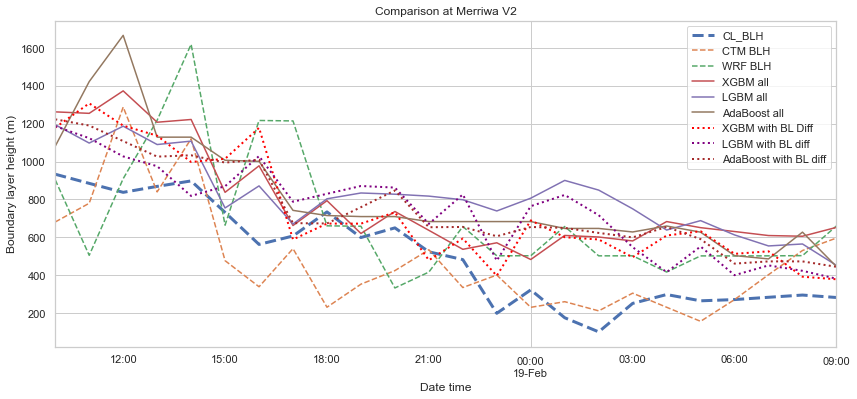

In [110]:
combined_predicted_plots_v2(df_combined_predicted_merriwa_v2, 'Comparison at Merriwa V2')

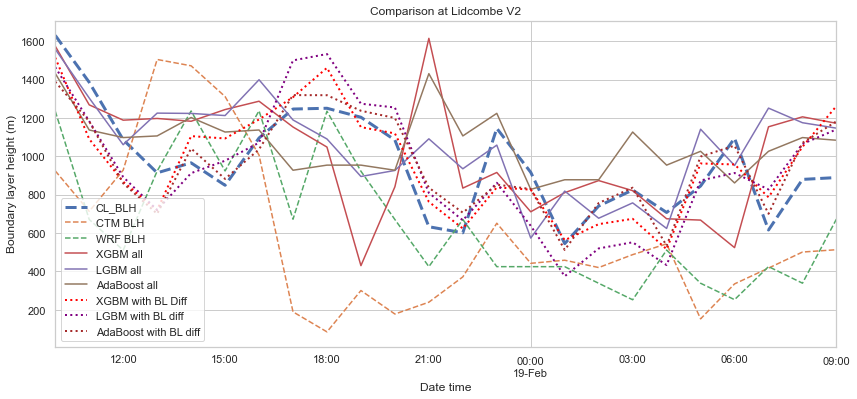

In [111]:
combined_predicted_plots_v2(df_combined_predicted_lidcombe_v2, 'Comparison at Lidcombe V2')

<h5>Incorporating lags into feature</h5>

In [112]:
results_df_merriwa_v3 = [df_merriwa_filled.tail(24)['CTM_BLH'],df_merriwa_filled.tail(24)['WRF_BLH'], 
        df_merriwa_xgbm_all['Predicted BLH'], df_merriwa_lgbm_all['Predicted BLH'], df_merriwa_ada_all['Predicted BLH'], 
        df_merriwa_xgbm_wlags['Predicted BLH'], df_merriwa_lgbm_wlags['Predicted BLH'], df_merriwa_ada_wlags['Predicted BLH']]

results_df_lidcombe_v3 = [df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'],
        df_lidcombe_xgbm_all['Predicted BLH'],df_lidcombe_lgbm_all['Predicted BLH'], df_lidcombe_ada_all['Predicted BLH'], 
        df_lidcombe_xgbm_wlags['Predicted BLH'],df_lidcombe_lgbm_wlags['Predicted BLH'], df_lidcombe_ada_wlags['Predicted BLH']]


col_names_df_v3 = ['CTM BLH', 'WRF BLH',
           'XGBM all', 'LGBM all', 'AdaBoost all', 
           'XGBM with lags', 'LGBM with lags', 'AdaBoost with lags']

df_combined_predicted_merriwa_v3 = combine_data_plots(df_merriwa_filled, results_df_merriwa_v3, col_names_df_v3)
df_combined_predicted_lidcombe_v3 = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_v3, col_names_df_v3)


In [113]:
def combined_predicted_plots_v3(df, title):
    ax = df.plot(figsize = (14,6), title = title)
    #Change settings for CL_BLH
    ax.lines[0].set_linestyle('dashed')
    ax.lines[0].set_linewidth(3)
    #Change settings for CTM BLH
    ax.lines[1].set_linestyle('dashed')
    ax.lines[2].set_linestyle('dashed')
    
    
    ax.lines[6].set_color('magenta')
    ax.lines[6].set_linestyle('dashdot')
    ax.lines[6].set_linewidth(2)
    
    ax.lines[7].set_color('purple')
    ax.lines[7].set_linestyle('dashdot')
    ax.lines[7].set_linewidth(2)

    ax.lines[8].set_color('brown')
    ax.lines[8].set_linestyle('dashdot')
    ax.lines[8].set_linewidth(2)

#     ax.lines[8].set_color('olive')
#     ax.lines[8].set_linestyle('dashdot')
#     ax.lines[8].set_linewidth(2)
    
#     ax.lines[9].set_color('magenta')
#     ax.lines[9].set_linestyle('dashdot')
#     ax.lines[9].set_linewidth(2)

#     ax.lines[10].set_color('purple')
#     ax.lines[10].set_linestyle('dashdot')
#     ax.lines[10].set_linewidth(2)
    
    #Reset legend
    ax.legend()
    plt.xlabel('Date time')
    plt.ylabel('Boundary layer height (m)')

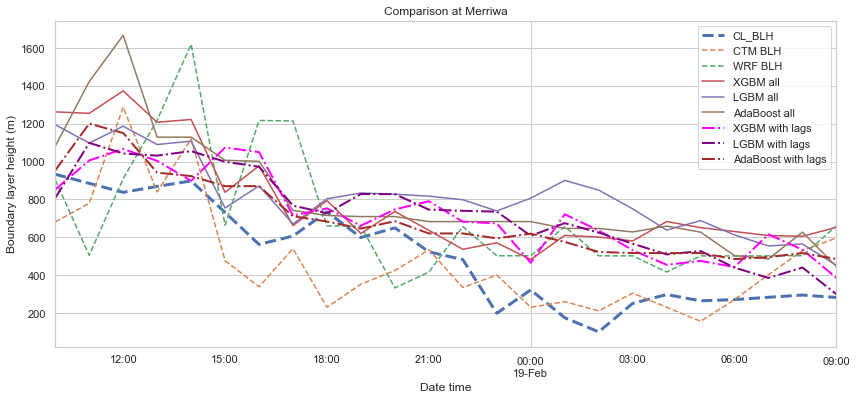

In [114]:
combined_predicted_plots_v3(df_combined_predicted_merriwa_v3, 'Comparison at Merriwa')

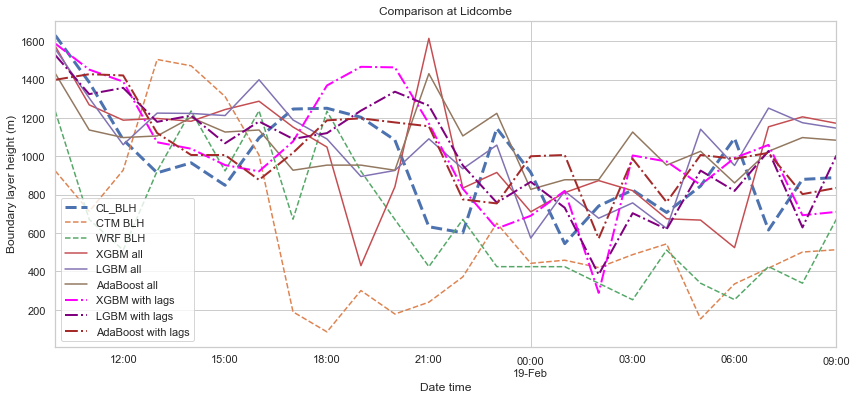

In [115]:
combined_predicted_plots_v3(df_combined_predicted_lidcombe_v3, 'Comparison at Lidcombe')

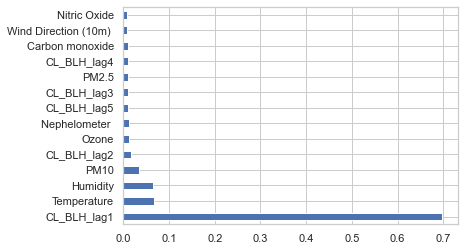

In [116]:
feature_importance_plot(rf_merriwa_wlags, feature_list_all_wlags)

So here we see that lag 1 is a very important feature

<h5>Comparing lags to BL diff feature</h5>

In [117]:
results_df_merriwa_v4 = [df_merriwa_filled.tail(24)['CTM_BLH'], 
        df_merriwa_xgbm_v2['Predicted BLH'], df_merriwa_lgbm_v2['Predicted BLH'], df_merriwa_ada_v2['Predicted BLH'], 
        df_merriwa_xgbm_wlags['Predicted BLH'], df_merriwa_lgbm_wlags['Predicted BLH'], df_merriwa_ada_wlags['Predicted BLH']]

results_df_lidcombe_v4 = [df_lidcombe_filled.tail(24)['CTM_BLH'], 
        df_lidcombe_xgbm_v2['Predicted BLH'],df_lidcombe_lgbm_v2['Predicted BLH'], df_lidcombe_ada_v2['Predicted BLH'], 
        df_lidcombe_xgbm_wlags['Predicted BLH'],df_lidcombe_lgbm_wlags['Predicted BLH'], df_lidcombe_ada_wlags['Predicted BLH']]


col_names_df_v4 = ['CTM BLH', 
           'XGBM with BL diff', 'LGBM with BL diff', 'AdaBoost with BL diff', 
           'XGBM with lags', 'LGBM with lags', 'AdaBoost with lags']

df_combined_predicted_merriwa_v4 = combine_data_plots(df_merriwa_filled, results_df_merriwa_v4, col_names_df_v4)
df_combined_predicted_lidcombe_v4 = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_v4, col_names_df_v4)


In [118]:
def combined_predicted_plots_v4(df, title):
    ax = df.plot(figsize = (14,6), title = title)
    #Change settings for CL_BLH
    ax.lines[0].set_linestyle('dashed')
    ax.lines[0].set_linewidth(3)
    #Change settings for CTM BLH
    ax.lines[1].set_linestyle('dashed')
    
    #With BL diff dfs
    ax.lines[2].set_color('green')
    ax.lines[2].set_linestyle('dotted')
    ax.lines[2].set_linewidth(2)
    
    ax.lines[3].set_color('red')
    ax.lines[3].set_linestyle('dotted')
    ax.lines[3].set_linewidth(2)

    ax.lines[4].set_color('purple')
    ax.lines[4].set_linestyle('dotted')
    ax.lines[4].set_linewidth(2)
    
    #With lags df
    ax.lines[5].set_color('olive')
    ax.lines[5].set_linestyle('dashdot')
    ax.lines[5].set_linewidth(2)
    
    ax.lines[6].set_color('magenta')
    ax.lines[6].set_linestyle('dashdot')
    ax.lines[6].set_linewidth(2)

    ax.lines[7].set_color('purple')
    ax.lines[7].set_linestyle('dashdot')
    ax.lines[7].set_linewidth(2)
    
    #Reset legend
    ax.legend()
    plt.xlabel('Date time')
    plt.ylabel('Boundary layer height (m)')

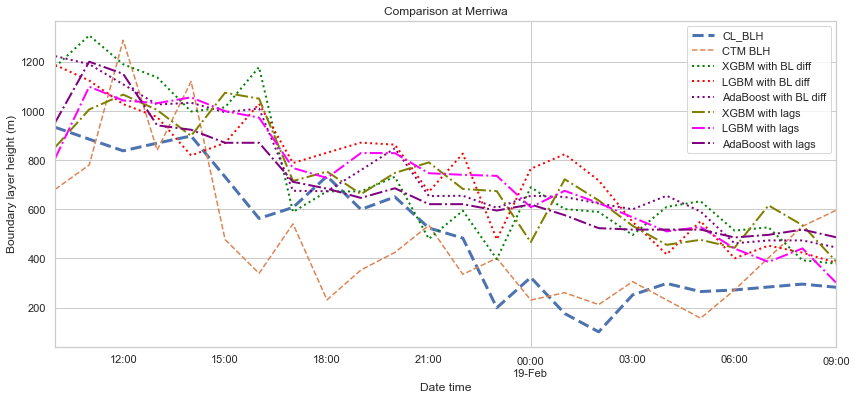

In [119]:
combined_predicted_plots_v4(df_combined_predicted_merriwa_v4, 'Comparison at Merriwa')

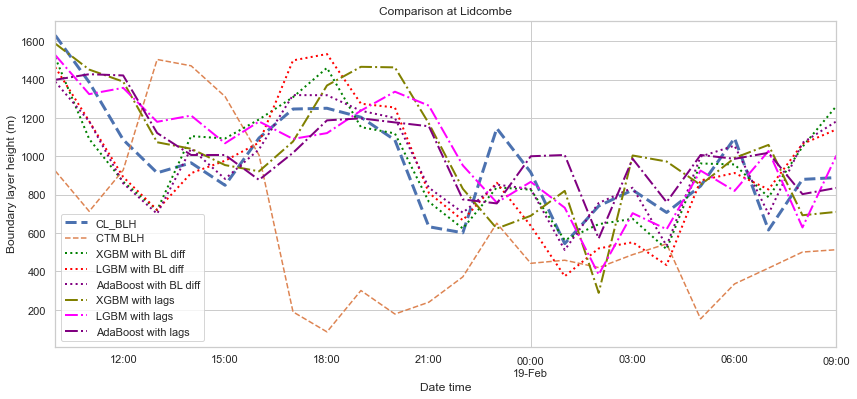

In [120]:
combined_predicted_plots_v4(df_combined_predicted_lidcombe_v4, 'Comparison at Lidcombe')

So here we see - its a bit hard... - that predictors with lags perform better than without lags

<h5>Comparing lags to diff</h5>

In [121]:
results_df_merriwa_v5 = [df_merriwa_filled.tail(24)['CTM_BLH'], 
        df_merriwa_xgbm_wlags['Predicted BLH'], df_merriwa_lgbm_wlags['Predicted BLH'], df_merriwa_ada_wlags['Predicted BLH'],
        df_merriwa_xgbm_wlags_v2['Predicted BLH'], df_merriwa_lgbm_wlags_v2['Predicted BLH'], df_merriwa_ada_wlags_v2['Predicted BLH']]

results_df_lidcombe_v5 = [df_lidcombe_filled.tail(24)['CTM_BLH'], 
        df_lidcombe_xgbm_wlags['Predicted BLH'],df_lidcombe_lgbm_wlags['Predicted BLH'], df_lidcombe_ada_wlags['Predicted BLH'],
        df_lidcombe_xgbm_wlags_v2['Predicted BLH'],df_lidcombe_lgbm_wlags_v2['Predicted BLH'], df_lidcombe_ada_wlags_v2['Predicted BLH']]


col_names_df_v5 = ['CTM BLH', 
           'XGBM with lags', 'LGBM with lags', 'AdaBoost with lags',
           'XGBM with lags + diff', 'LGBM with lags + diff', 'AdaBoost with lags + diff']

df_combined_predicted_merriwa_v5 = combine_data_plots(df_merriwa_filled, results_df_merriwa_v5, col_names_df_v5)
df_combined_predicted_lidcombe_v5 = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_v5, col_names_df_v5)


In [122]:
def combined_predicted_plots_v5(df, title):
    ax = df.plot(figsize = (14,6), title = title)
    #Change settings for CL_BLH
    ax.lines[0].set_linestyle('dashed')
    ax.lines[0].set_linewidth(3)
    #Change settings for CTM BLH
    ax.lines[1].set_linestyle('dashed')
    
#     #With BL diff dfs
#     ax.lines[2].set_color('green')
#     ax.lines[2].set_linestyle('dotted')
#     ax.lines[2].set_linewidth(2)
    
#     ax.lines[3].set_color('red')
#     ax.lines[3].set_linestyle('dotted')
#     ax.lines[3].set_linewidth(2)

#     ax.lines[4].set_color('purple')
#     ax.lines[4].set_linestyle('dotted')
#     ax.lines[4].set_linewidth(2)
    
    #With lags df
    ax.lines[2].set_color('olive')
    ax.lines[2].set_linestyle('dashdot')
    ax.lines[2].set_linewidth(2)
    
    ax.lines[3].set_color('magenta')
    ax.lines[3].set_linestyle('dashdot')
    ax.lines[3].set_linewidth(2)

    ax.lines[4].set_color('purple')
    ax.lines[4].set_linestyle('dashdot')
    ax.lines[4].set_linewidth(2)
    
    #With lags + diff
    ax.lines[5].set_color('olive')
#     ax.lines[5].set_linestyle('dashdot')
#     ax.lines[5].set_linewidth(2)
    
    ax.lines[6].set_color('magenta')
#     ax.lines[6].set_linestyle('dashdot')
#     ax.lines[6].set_linewidth(2)

    ax.lines[7].set_color('purple')
#     ax.lines[7].set_linestyle('dashdot')
#     ax.lines[7].set_linewidth(2)
    
    #Reset legend
    ax.legend()
    plt.xlabel('Date time')
    plt.ylabel('Boundary layer height (m)')

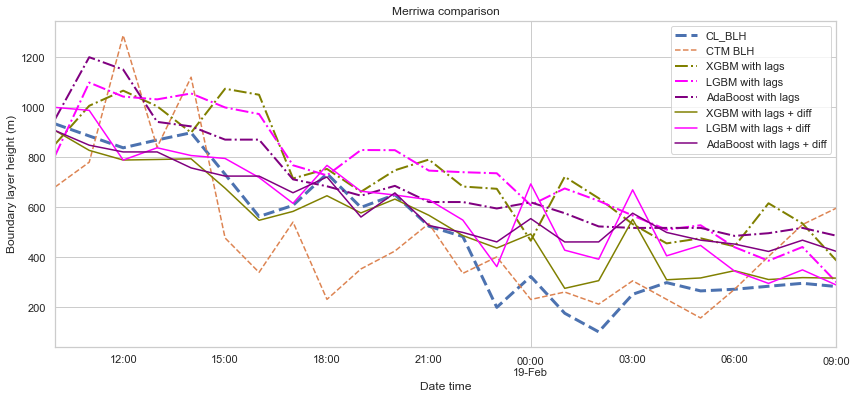

In [123]:
combined_predicted_plots_v5(df_combined_predicted_merriwa_v5, "Merriwa comparison")

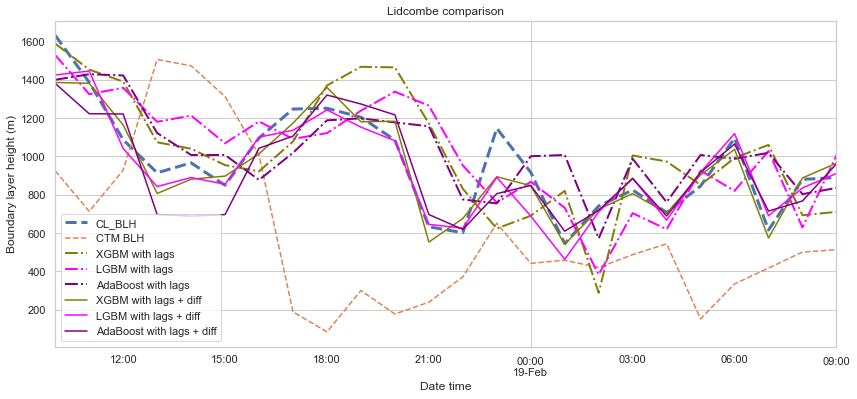

In [124]:
combined_predicted_plots_v5(df_combined_predicted_lidcombe_v5, "Lidcombe comparison")

<h4>More presentable results</h4>

For Friday

In [128]:
results_df_merriwa_extfact = [df_merriwa_filled.tail(24)['CTM_BLH'],df_merriwa_filled.tail(24)['WRF_BLH'], 
        df_merriwa_xgbm_all['Predicted BLH'], df_merriwa_lgbm_all['Predicted BLH'], df_merriwa_ada_all['Predicted BLH']] 

results_df_lidcombe_extfact = [df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'],
        df_lidcombe_xgbm_all['Predicted BLH'],df_lidcombe_lgbm_all['Predicted BLH'], df_lidcombe_ada_all['Predicted BLH']]
                         
col_names_df_extfact = ['CTM BLH', 'WRF BLH',
           'XGBM all external factors', 'LGBM all external factors', 'AdaBoost all external factors']

results_df_merriwa_wlags_v2 = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'],
        df_merriwa_xgbm_wlags_v2['Predicted BLH'], df_merriwa_lgbm_wlags_v2['Predicted BLH'], df_merriwa_ada_wlags_v2['Predicted BLH']]

results_df_lidcombe_wlags_v2 = [df_lidcombe_filled.tail(24)['CTM_BLH'],   df_lidcombe_filled.tail(24)['WRF_BLH'],
        df_lidcombe_xgbm_wlags_v2['Predicted BLH'],df_lidcombe_lgbm_wlags_v2['Predicted BLH'], df_lidcombe_ada_wlags_v2['Predicted BLH']]

col_names_df_wlags_v2 = ['CTM BLH', 'WRF BLH',
           'XGBM with lags and differences up to 5', 'LGBM with lags and differences up to 5', 'AdaBoost with lags and differences up to 5']

df_combined_predicted_merriwa_extfact = combine_data_plots(df_merriwa_filled, results_df_merriwa_extfact, col_names_df_extfact)
df_combined_predicted_lidcombe_extfact = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_extfact, col_names_df_extfact)

df_combined_predicted_merriwa_wlags_v2 = combine_data_plots(df_merriwa_filled, results_df_merriwa_wlags_v2, col_names_df_wlags_v2)
df_combined_predicted_lidcombe_wlags_v2 = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_wlags_v2, col_names_df_wlags_v2)

In [129]:
def combined_predicted_plots_extfact(df, title):
    ax = df.plot(figsize = (14,6), title = title)
    #Change settings for CL_BLH
    ax.lines[0].set_linestyle('dashed')
    ax.lines[0].set_linewidth(3)
    #Change settings for CTM/WRF BLH
    ax.lines[1].set_linestyle('dashed')
    ax.lines[2].set_linestyle('dashed')
    #Reset legend
    ax.legend()
    plt.xlabel('Date time')
    plt.ylabel('Boundary layer height (m)')
    plt.ylim(0,1800)

In [130]:
def combined_predicted_plots_wlags_v2(df, title):
    ax = df.plot(figsize = (14,6), title = title)
    #Change settings for CL_BLH
    ax.lines[0].set_linestyle('dashed')
    ax.lines[0].set_linewidth(3)
    #Change settings for CTM BLH
    ax.lines[1].set_linestyle('dashed')
    ax.lines[2].set_linestyle('dashed')
 
    #With lags df
    ax.lines[3].set_color('red')
    ax.lines[3].set_linestyle('dashdot')
    ax.lines[3].set_linewidth(2)
    
    ax.lines[4].set_color('purple')
    ax.lines[4].set_linestyle('dashdot')
    ax.lines[4].set_linewidth(2)

    ax.lines[5].set_color('brown')
    ax.lines[5].set_linestyle('dashdot')
    ax.lines[5].set_linewidth(2)
    
    #Reset legend
    ax.legend()
    plt.xlabel('Date time')
    plt.ylabel('Boundary layer height (m)')
    plt.ylim(0,1800)

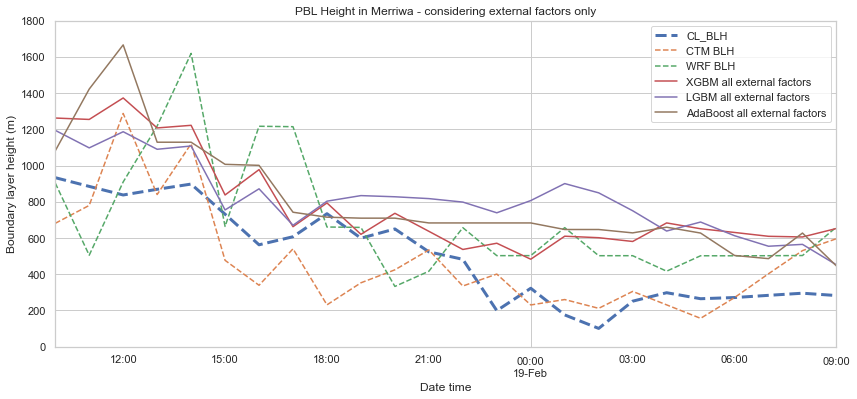

In [131]:
combined_predicted_plots_extfact(df_combined_predicted_merriwa_extfact, 'PBL Height in Merriwa - considering external factors only')

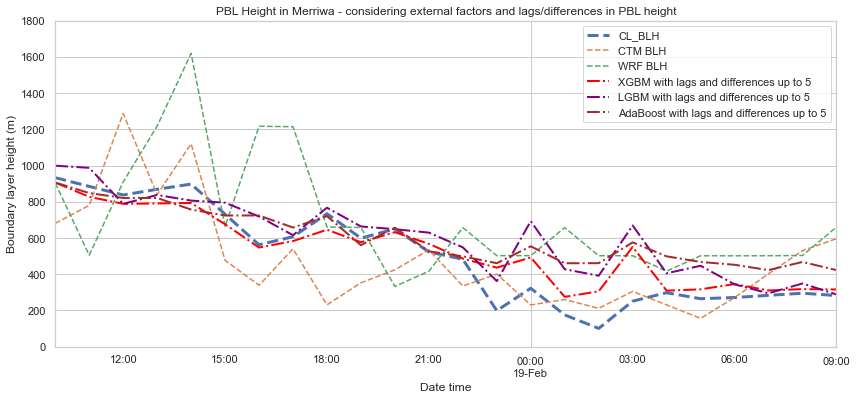

In [132]:
combined_predicted_plots_wlags_v2(df_combined_predicted_merriwa_wlags_v2, 'PBL Height in Merriwa - considering external factors and lags/differences in PBL height')

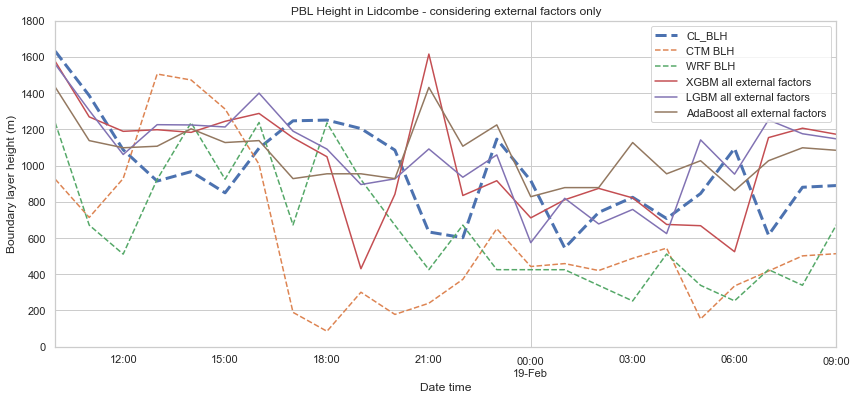

In [133]:
combined_predicted_plots_extfact(df_combined_predicted_lidcombe_extfact, 'PBL Height in Lidcombe - considering external factors only')

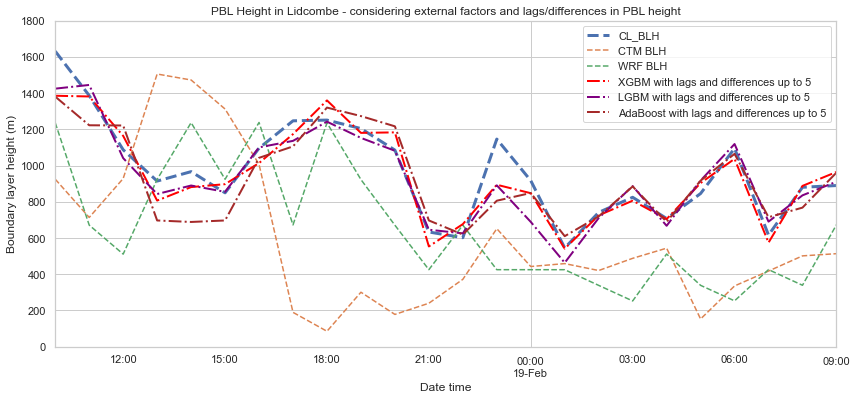

In [134]:
combined_predicted_plots_wlags_v2(df_combined_predicted_lidcombe_wlags_v2, 'PBL Height in Lidcombe - considering external factors and lags/differences in PBL height')

<h5>For final report</h5>

In [145]:
results_df_merriwa_wlags_v2_xgbm = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'],
        df_merriwa_xgbm_wlags_v2['Predicted BLH']]

results_df_merriwa_wlags_v2_lgbm = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'], 
                                    df_merriwa_lgbm_wlags_v2['Predicted BLH']]

results_df_merriwa_wlags_v2_ada = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'], 
                                   df_merriwa_ada_wlags_v2['Predicted BLH']]


results_df_lidcombe_wlags_v2_xgbm = [df_lidcombe_filled.tail(24)['CTM_BLH'],   df_lidcombe_filled.tail(24)['WRF_BLH'],
        df_lidcombe_xgbm_wlags_v2['Predicted BLH']]

results_df_lidcombe_wlags_v2_lgbm = [df_lidcombe_filled.tail(24)['CTM_BLH'],   df_lidcombe_filled.tail(24)['WRF_BLH'],
                                     df_lidcombe_lgbm_wlags_v2['Predicted BLH']]

results_df_lidcombe_wlags_v2_ada =[df_lidcombe_filled.tail(24)['CTM_BLH'],   df_lidcombe_filled.tail(24)['WRF_BLH'] , 
                                   df_lidcombe_ada_wlags_v2['Predicted BLH']]

col_names_df_wlags_v2_xgbm = ['CTM BLH', 'WRF BLH',
                       'XGBM model prediction']
col_names_df_wlags_v2_lgbm = ['CTM BLH', 'WRF BLH', 'LGBM model prediction']
col_names_df_wlags_v2_ada = ['CTM BLH', 'WRF BLH', 'AdaBoost model prediction']

df_combined_predicted_merriwa_wlags_v2_xgbm = combine_data_plots(df_merriwa_filled, results_df_merriwa_wlags_v2_xgbm, col_names_df_wlags_v2_xgbm)
df_combined_predicted_merriwa_wlags_v2_lgbm = combine_data_plots(df_merriwa_filled, results_df_merriwa_wlags_v2_lgbm, col_names_df_wlags_v2_lgbm)
df_combined_predicted_merriwa_wlags_v2_ada = combine_data_plots(df_merriwa_filled, results_df_merriwa_wlags_v2_ada, col_names_df_wlags_v2_ada)

df_combined_predicted_lidcombe_wlags_v2_xgbm = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_wlags_v2_xgbm, col_names_df_wlags_v2_xgbm)
df_combined_predicted_lidcombe_wlags_v2_lgbm = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_wlags_v2_lgbm, col_names_df_wlags_v2_lgbm)
df_combined_predicted_lidcombe_wlags_v2_ada = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_wlags_v2_ada, col_names_df_wlags_v2_ada)

In [146]:
def combined_predicted_plots_wlags_v3(df, title):
    ax = df.plot(figsize = (14,6), title = title)
    #Change settings for CL_BLH
    ax.lines[0].set_linestyle('dashed')
    ax.lines[0].set_linewidth(3)
    #Change settings for CTM BLH
    ax.lines[1].set_linestyle('dashed')
    ax.lines[2].set_linestyle('dashed')
     
    #Reset legend
    ax.legend()
    plt.xlabel('Date time')
    plt.ylabel('Boundary layer height (m)')
    plt.ylim(0,1800)

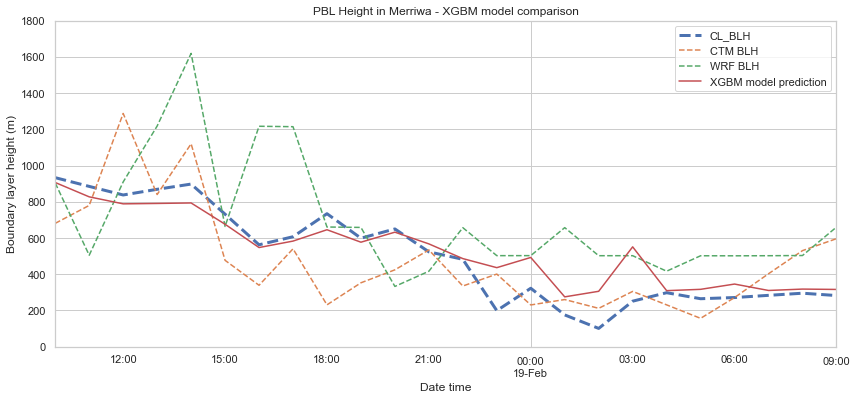

In [147]:
combined_predicted_plots_wlags_v3(df_combined_predicted_merriwa_wlags_v2_xgbm, 'PBL Height in Merriwa - XGBM model comparison')

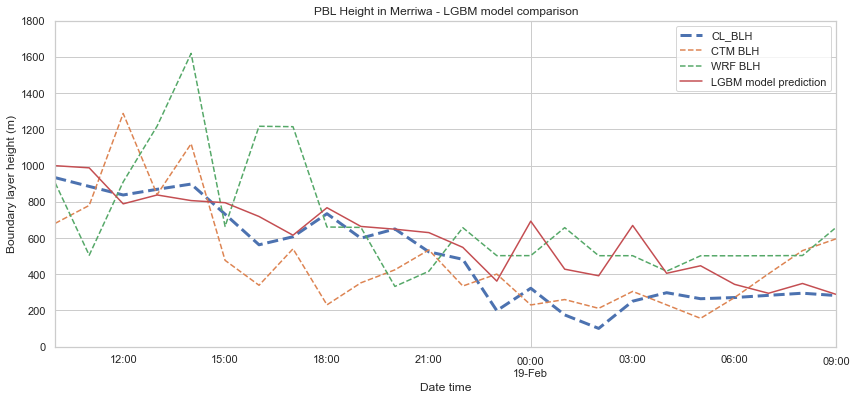

In [148]:
combined_predicted_plots_wlags_v3(df_combined_predicted_merriwa_wlags_v2_lgbm, 'PBL Height in Merriwa - LGBM model comparison')

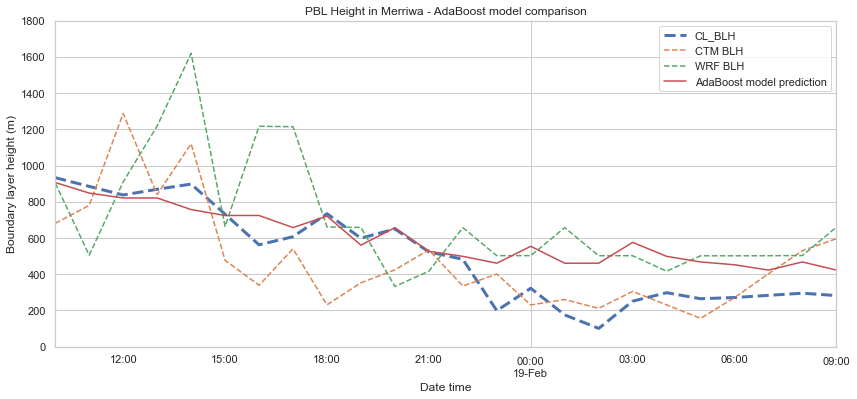

In [149]:
combined_predicted_plots_wlags_v3(df_combined_predicted_merriwa_wlags_v2_ada, 'PBL Height in Merriwa - AdaBoost model comparison')

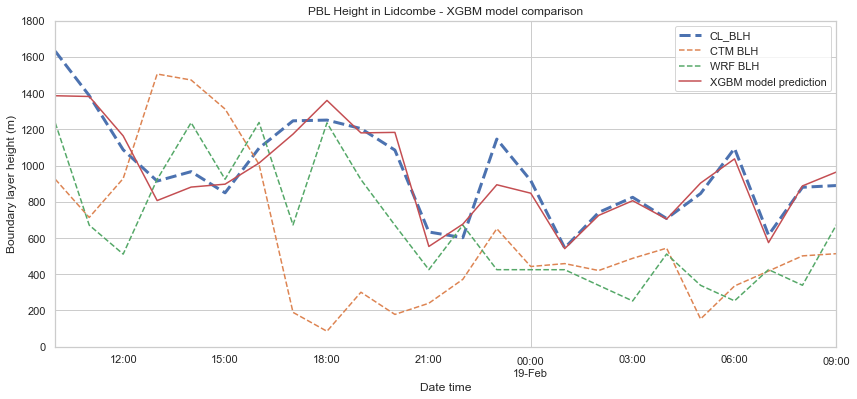

In [150]:
combined_predicted_plots_wlags_v3(df_combined_predicted_lidcombe_wlags_v2_xgbm, 'PBL Height in Lidcombe - XGBM model comparison')

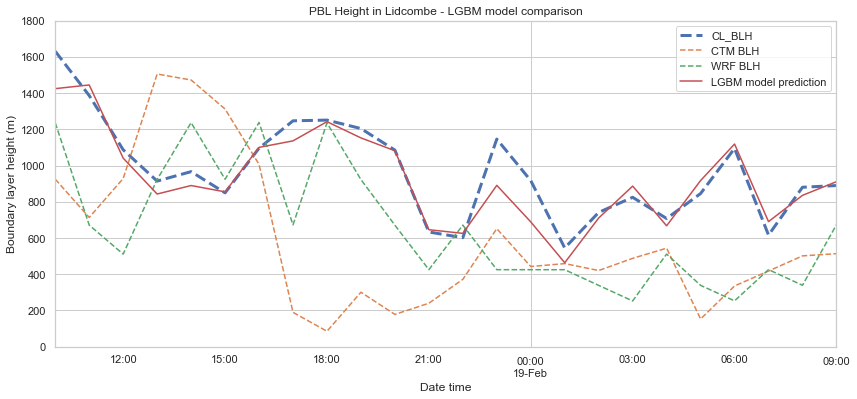

In [151]:
combined_predicted_plots_wlags_v3(df_combined_predicted_lidcombe_wlags_v2_lgbm, 'PBL Height in Lidcombe - LGBM model comparison')

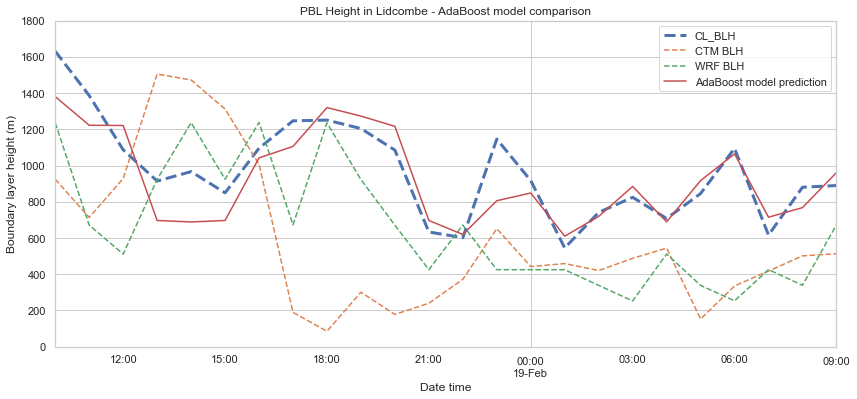

In [152]:
combined_predicted_plots_wlags_v3(df_combined_predicted_lidcombe_wlags_v2_ada, 'PBL Height in Lidcombe - AdaBoost model comparison')

<h4>Writing a massive DF for all the results - for comparison purposes</h4>

In [135]:
results_df_merriwa_all = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'],
        df_merriwa_xgbm_all['Predicted BLH'], df_merriwa_lgbm_all['Predicted BLH'], df_merriwa_ada_all['Predicted BLH'],                   
        df_merriwa_xgbm_v2['Predicted BLH'], df_merriwa_lgbm_v2['Predicted BLH'], df_merriwa_ada_v2['Predicted BLH'], 
        df_merriwa_xgbm_wlags['Predicted BLH'], df_merriwa_lgbm_wlags['Predicted BLH'], df_merriwa_ada_wlags['Predicted BLH'],
        df_merriwa_xgbm_wlags_v2['Predicted BLH'], df_merriwa_lgbm_wlags_v2['Predicted BLH'], df_merriwa_ada_wlags_v2['Predicted BLH']]


results_df_lidcombe_all = [df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'],
        df_lidcombe_xgbm_all['Predicted BLH'], df_lidcombe_lgbm_all['Predicted BLH'], df_lidcombe_ada_all['Predicted BLH'],                   
        df_lidcombe_xgbm_v2['Predicted BLH'], df_lidcombe_lgbm_v2['Predicted BLH'], df_lidcombe_ada_v2['Predicted BLH'], 
        df_lidcombe_xgbm_wlags['Predicted BLH'], df_lidcombe_lgbm_wlags['Predicted BLH'], df_lidcombe_ada_wlags['Predicted BLH'],
        df_lidcombe_xgbm_wlags_v2['Predicted BLH'], df_lidcombe_lgbm_wlags_v2['Predicted BLH'], df_lidcombe_ada_wlags_v2['Predicted BLH']]


col_names_df_all = ['CTM BLH', 'WRF BLH', 
           'XGBM all', 'LGBM all', 'AdaBoost all',         
           'XGBM with BL diff', 'LGBM with BL diff', 'AdaBoost with BL diff', 
           'XGBM with lags (up to 5)', 'LGBM with lags (up to 5)', 'AdaBoost with lags (up to 5)',
            'XGBM with lags and differences (up to 5)', 'LGBM with lags and differences (up to 5)', 'AdaBoost with lags and differences (up to 5)',]


In [141]:
#Function that writes out df for all results
def df_stat_results_combined(df_filled, results_df, train_series, col_names_df):
    index_dict = {0:'IOA', 1:'RMSE', 2:'MAE', 3:'MBE', 4:'DTW DIST', 5:'MASE'}
    
    y_true = df_filled.tail(24)['CL_BLH']
    
    #The first one is the CTM model
    y_pred = results_df[0]
    
    #Intialises the DF
    df_combined = satistical_comps_on_df_to_df(y_true, y_pred, train_series)
    df_combined = df_combined.rename(columns = {0:'CTM model'})
    
    #Iterate
    for i in range(1, len(results_df)):
        y_pred_i = results_df[i]
        df_results_i = satistical_comps_on_df_to_df(y_true, y_pred_i, train_series)        
        df_combined[col_names_df[i]] = df_results_i

    df_combined = df_combined.rename(index = index_dict)    
    
    return df_combined

In [143]:
df_stat_results_combined(df_merriwa_filled, results_df_merriwa_all,df_merriwa_filled.head(142)['CL_BLH'], col_names_df_all).to_csv('Merriwa_summary_v3.csv')

In [144]:
df_stat_results_combined(df_lidcombe_filled, results_df_lidcombe_all,df_lidcombe_filled.head(142)['CL_BLH'], col_names_df_all).to_csv('Lidcombe_summary_v3.csv')

That's pretty close....

ELM?

https://towardsdatascience.com/ml-approaches-for-time-series-4d44722e48fe

https://towardsdatascience.com/introduction-to-extreme-learning-machines-c020020ff82b

<h1>NOT USED - TK PLAY</H1>

<h4> Stationarity checks</h4>

In [18]:
from statsmodels.tsa.stattools import adfuller

#Augmented Dicky Fuller test for stationarity
#H0: Process is not stationary

def adf_test(series):
    adf_test_result = adfuller(series)
    print('ADF stat %0.5f' % adf_test_result[0])
    print('p-val %0.5f' % adf_test_result[1])
    
adf_test(df_merriwa['CL_BLH'])
adf_test(df_lidcombe['CL_BLH'])

#Looks stationary..

<h4>ARIMA</h4>

In [15]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

In [18]:
auto_arima_merriwa = auto_arima(df_merriwa_cl['CL_BLH'], trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2282.558, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2283.058, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2283.277, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2280.793, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2284.761, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.814 seconds


In [19]:
auto_arima_merriwa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  166
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1139.396
Date:                Thu, 29 Jul 2021   AIC                           2280.793
Time:                        11:54:18   BIC                           2283.899
Sample:                             0   HQIC                          2282.054
                                - 166                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.841e+04   4885.664     11.955      0.000    4.88e+04     6.8e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.61   Jarque-Bera (JB):                15.07
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                            -0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
arima_merriwa = ARIMA(df_merriwa_cl['CL_BLH'], order=(0,1,0))
print(arima_merriwa.fit().summary())

                               SARIMAX Results                                
Dep. Variable:                 CL_BLH   No. Observations:                  166
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1139.396
Date:                Thu, 29 Jul 2021   AIC                           2280.793
Time:                        11:54:22   BIC                           2283.899
Sample:                             0   HQIC                          2282.054
                                - 166                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.841e+04   4885.664     11.955      0.000    4.88e+04     6.8e+04
Ljung-Box (L1) (Q):                   1.61   Jarque-Bera (JB):                15.07
Prob(Q):                              0.20   Pr

In [52]:
t = ()

if not t:
    print('empty')

empty


In [54]:
t = []

stuff = (1,2,3)

t.extend(stuff)

tuple(t)

(1, 2, 3)

Cool. What does this mean?
How to use auto_arima to get params right?

Trad TS models lack the ability to fit causal relationships easily. Could extend this by predicting the predictors but that would require first feature selection.

Perhaps this could be briefly tried?